# SensoRehab research kit

In [5]:
%pip install httpx
%pip install pandas
%pip install scipy
%pip install matplotlib
%pip install tables


[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 2.0 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 988.1/988.1 kB 4.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 2.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
import io
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.spatial import transform as scipy_transform

# Data fetching

In [7]:
import os

import httpx


def fetch_data():    
    try:
        url = os.environ['CLICKHOUSE_URL']
        credentials = {
            "user": os.environ['CLICKHOUSE_USER'],
            "password": os.environ['CLICKHOUSE_PASSWORD'],
        }
    except KeyError:
        print(
            'You have to setup env vars to fetch full dataset. '
            'Contact alex@sensorehab.com to discuss details.'
        )
        return

    response = httpx.Client().get(
        url=url,
        params={
            "query": 'SELECT * FROM raw_data FORMAT CSV',
            **credentials,
        },
    )
    return response.text

In [8]:
# Fetches a dataset if there is no saved one in the data folder.

df = None
try:
    df = pd.read_hdf('./data/sample_gross_dataset.h5')
except FileNotFoundError:
    print('Data fetching...')
    dataset_str = fetch_data()
    print(dataset_str[:200])

In [9]:
# Converts a fetched dataset into pd format and saves it.

if df is None:
    df = pd.read_csv(
        io.StringIO(dataset_str),
        names=[
            'game_result_id', 'game_id', 'patient_id', 'exercise_id',
            'timestamp', 'src', 'side', 'h_rssi', 'h_gain', 'g_rssi', 'g_gain',
            'forearm_quat_x', 'forearm_quat_y', 'forearm_quat_z',
            'forearm_quat_w', 'forearm_lia_x', 'forearm_lia_y',
            'forearm_lia_z', 'forearm_grv_x', 'forearm_grv_y', 'forearm_grv_z',
            'forearm_tilt', 'shoulder_quat_x', 'shoulder_quat_y',
            'shoulder_quat_z', 'shoulder_quat_w', 'shoulder_lia_x',
            'shoulder_lia_y', 'shoulder_lia_z', 'shoulder_grv_x',
            'shoulder_grv_y', 'shoulder_grv_z', 'shoulder_tilt',
            'position_type',
        ],
    )
    df.to_hdf('./data/sample_gross_dataset.h5', key='df', mode='w')

# Discover data

In [10]:
df.head(5)

game_result_id  game_id  patient_id  exercise_id            timestamp   
259320           13625       12         612            8  1997-10-24 13:08:12  \
259321           13625       12         612            8  1997-10-24 13:08:26   
259322           13625       12         612            8  1997-10-24 13:08:42   
259323           13625       12         612            8  1997-10-24 13:08:59   
259324           13625       12         612            8  1997-10-24 13:09:16   

                      src  side  h_rssi  h_gain  g_rssi  ...  shoulder_quat_z   
259320  00:00:00:00:00:00     1     -99       0       0  ...         0.001092  \
259321  00:00:00:00:00:00     1     -99       0       0  ...         0.000769   
259322  00:00:00:00:00:00     1     -99       0       0  ...         0.000811   
259323  00:00:00:00:00:00     1     -99       0       0  ...         0.000811   
259324  00:00:00:00:00:00     1     -99       0       0  ...         0.000879   

        shoulder_quat_w  shoulder_lia_x  shoulder_lia_y  shoulder_lia_z   
259320         0.589777          -0.150           0.105           0.050  \
259321         0.589570          -0.086           0.072           0.085   
259322         0.589508          -0.093           0.008           0.056   
259323         0.589508          -0.094           0.012           0.056   
259324         0.589537           0.013          -0.020           0.033   

        shoulder_grv_x  shoulder_grv_y  shoulder_grv_z  shoulder_tilt   
259320          -6.926          -6.411          -2.861       0.710358  \
259321          -6.931          -6.421          -2.943       0.710137   
259322          -6.945          -6.353          -2.957       0.710272   
259323          -6.945          -6.353          -2.957       0.710272   
259324          -6.888          -6.333          -3.054       0.710307   

        position_type  
259320              0  
259321              0  
259322              0  
259323              0  
259324              0  

[5 rows x 34 columns]

In [11]:
df.describe()

game_result_id  game_id    patient_id   exercise_id          side   
count    35965.000000  35965.0  35965.000000  35965.000000  35965.000000  \
mean     13534.025330     12.0    612.799555      7.900181      1.699847   
std        116.389269      0.0      0.979719      0.299763      0.458331   
min      13391.000000     12.0    612.000000      7.000000      1.000000   
25%      13391.000000     12.0    612.000000      8.000000      1.000000   
50%      13625.000000     12.0    612.000000      8.000000      2.000000   
75%      13633.000000     12.0    614.000000      8.000000      2.000000   
max      13633.000000     12.0    614.000000      8.000000      2.000000   

             h_rssi   h_gain   g_rssi   g_gain  forearm_quat_x  ...   
count  35965.000000  35965.0  35965.0  35965.0    35965.000000  ...  \
mean     -59.411011      0.0      0.0      0.0        0.696816  ...   
std       48.498322      0.0      0.0      0.0        0.213015  ...   
min      -99.000000      0.0      0.0      0.0        0.000125  ...   
25%      -99.000000      0.0      0.0      0.0        0.579443  ...   
50%      -99.000000      0.0      0.0      0.0        0.772387  ...   
75%        0.000000      0.0      0.0      0.0        0.839940  ...   
max        0.000000      0.0      0.0      0.0        0.979611  ...   

       shoulder_quat_z  shoulder_quat_w  shoulder_lia_x  shoulder_lia_y   
count     35965.000000     35965.000000    35965.000000    35965.000000  \
mean          0.029324         0.188014       -0.016307       -0.004875   
std           0.348748         0.542681        0.220406        0.230742   
min          -0.660027        -0.807520       -3.378000       -3.324000   
25%          -0.076819        -0.117430       -0.097000       -0.083000   
50%           0.043518         0.010922       -0.015000        0.003000   
75%           0.116174         0.719306        0.063000        0.078000   
max           0.651814         0.816082        3.504000        2.713000   

       shoulder_lia_z  shoulder_grv_x  shoulder_grv_y  shoulder_grv_z   
count    35965.000000    35965.000000    35965.000000    35965.000000  \
mean         0.023872       -6.296706       -5.935627       -3.909695   
std          0.174816        1.680654        0.966683        1.706625   
min         -2.515000       -9.314000      -10.726000       -9.973000   
25%         -0.032000       -7.234000       -6.663000       -4.352000   
50%          0.022000       -6.924000       -5.960000       -3.808000   
75%          0.078000       -6.319000       -5.442000       -3.044000   
max          2.984000        0.024000       -1.165000        2.082000   

       shoulder_tilt  position_type  
count   35965.000000   35965.000000  
mean        0.468661       0.005895  
std         0.399318       0.098756  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.654115       0.000000  
75%         0.740736       0.000000  
max         1.089239       2.000000  

[8 rows x 32 columns]

In [12]:
print(f"{len(df['patient_id'].unique())} patients, {len(df['game_result_id'].unique())} game results")

2 patients, 4 game results


# Calculate angle and velocity features

In [13]:
def calc_ang_to_Y(row):
    w, x, y, z = row.to_list()
    rotation = scipy_transform.Rotation.from_quat([x, y, z, w])
    vec = rotation.apply([0, 1, 0])
    rad_angle = np.arcsin(vec[2])
    deg_angle = math.degrees(rad_angle)
    return -deg_angle

In [14]:
forearm_quat = [
    'forearm_quat_x', 
    'forearm_quat_y', 
    'forearm_quat_z', 
    'forearm_quat_w',
]
df['forearm_y_ang'] = df[forearm_quat].apply(calc_ang_to_Y, axis=1)

In [15]:
shoulder_quat = [
    'shoulder_quat_x',
    'shoulder_quat_y',
    'shoulder_quat_z',
    'shoulder_quat_w',
]
df['shoulder_y_ang'] = df[shoulder_quat].apply(calc_ang_to_Y, axis=1)

In [16]:
def calc_forearm_shoulder_ang(row):    
    forearm_rotation = scipy_transform.Rotation.from_quat(row.to_list()[:4])
    shoulder_rotation = scipy_transform.Rotation.from_quat(row.to_list()[4:])
    forearm_vec = forearm_rotation.apply([0, 1, 0])
    shoulder_vec = shoulder_rotation.apply([0, 1, 0])
    dot_product = np.dot(forearm_vec / np.linalg.norm(forearm_vec),
                         shoulder_vec / np.linalg.norm(shoulder_vec))
    rad_angle = np.arccos(dot_product)
    deg_angle = math.degrees(rad_angle)
    return deg_angle

In [17]:
forearm_shoulder_quats = [
    'forearm_quat_x', 
    'forearm_quat_y', 
    'forearm_quat_z', 
    'forearm_quat_w',
    'shoulder_quat_x', 
    'shoulder_quat_y', 
    'shoulder_quat_z', 
    'shoulder_quat_w',
]
df['forearm_shoulder_ang'] = df[forearm_shoulder_quats].apply(
    calc_forearm_shoulder_ang, 
    axis=1
)

In [18]:
# Filters outliers.

df['forearm_lia_x'] = df['forearm_lia_x'][abs(df['forearm_lia_x']) < 25]
df['forearm_lia_y'] = df['forearm_lia_y'][abs(df['forearm_lia_y']) < 25]
df['forearm_lia_z'] = df['forearm_lia_z'][abs(df['forearm_lia_z']) < 25]
df['shoulder_lia_x'] = df['shoulder_lia_x'][abs(df['shoulder_lia_x']) < 25]
df['shoulder_lia_y'] = df['shoulder_lia_y'][abs(df['shoulder_lia_y']) < 25]
df['shoulder_lia_z'] = df['shoulder_lia_z'][abs(df['shoulder_lia_z']) < 25]

# Discover game sessions

In [19]:
def plot_game_result(result_id, feature):
    defprops = {
        'xdata': [],
        'ydata': [],
        'linestyle': 'None',
        'markersize': 10
    }
    black_arrow = mlines.Line2D(
        **defprops,
        marker='^',
        color='black',
        label='start position',
    )
    red_arrow = mlines.Line2D(
        **defprops,
        marker='v',
        color='red',
        label='end position',
    )
    plt.legend(handles=[black_arrow, red_arrow])

    result_df = df.loc[df['game_result_id'] == result_id].reset_index(drop=True)
    exercise_id = result_df['exercise_id'].unique()[0]
    patient_id = result_df['patient_id'].unique()[0]
    game_id = result_df['game_id'].unique()[0]

    # positionType = 1, labled by 'ArrowDown'. A hand in lower position.
    start_mark_locs = result_df.loc[result_df['position_type'] == 1].index
    # positionType = 2, labled by 'ArrowUp'. A hand in upper position.
    end_mark_locs = result_df.loc[result_df['position_type'] == 2].index    
    
    result_df[feature].plot(
        title=f'feature {feature}, patient {patient_id}, result {result_id}, exercise {exercise_id}, game {game_id}',
        figsize=(25, 6),
        color='tab:blue',
        marker='^',
        markersize=10,
        markerfacecolor='black',
        markevery=start_mark_locs,
    )
    result_df[feature].plot(
        figsize=(25, 6),
        color='tab:blue',
        marker='v',
        markersize=10,
        markerfacecolor='red',
        markevery=end_mark_locs,
    )
    plt.figure()

In [20]:
ALL_FEATURES = [
    'forearm_y_ang', 'forearm_shoulder_ang', 'shoulder_y_ang',
    'forearm_lia_x', 'forearm_lia_y', 'forearm_lia_z', 'shoulder_lia_x',
    'shoulder_lia_y', 'shoulder_lia_z'
]

def plot_all_game_result_features(result_id):
    for feature in ALL_FEATURES:
        plot_game_result(result_id, feature)

In [21]:
# There are 2 patients with two game results for each.

patient_ids = df['patient_id'].unique()
game_results_patient_1 = df.loc[df['patient_id'] == patient_ids[0]]['game_result_id'].unique()
game_results_patient_2 = df.loc[df['patient_id'] == patient_ids[1]]['game_result_id'].unique()
game_results_patient_1, game_results_patient_2

(array([13625, 13391]), array([13393, 13633]))

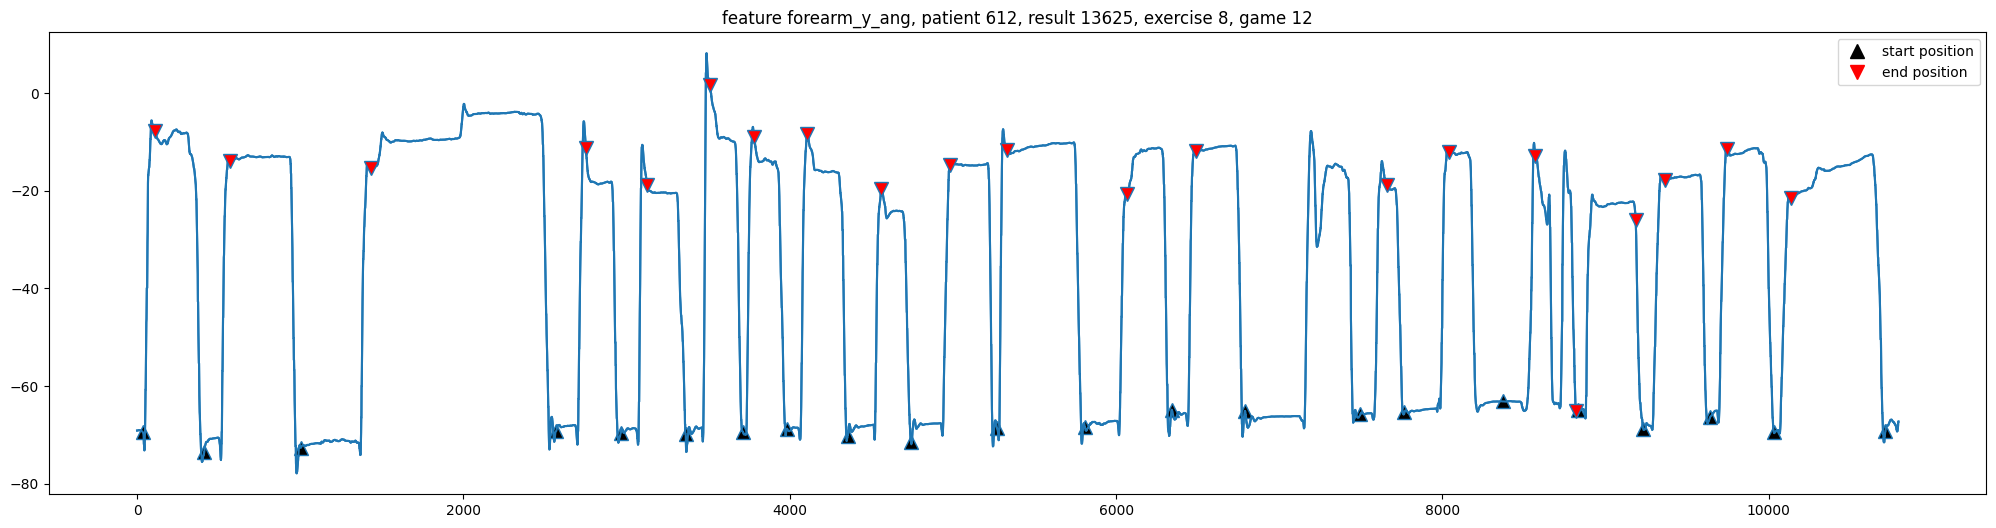

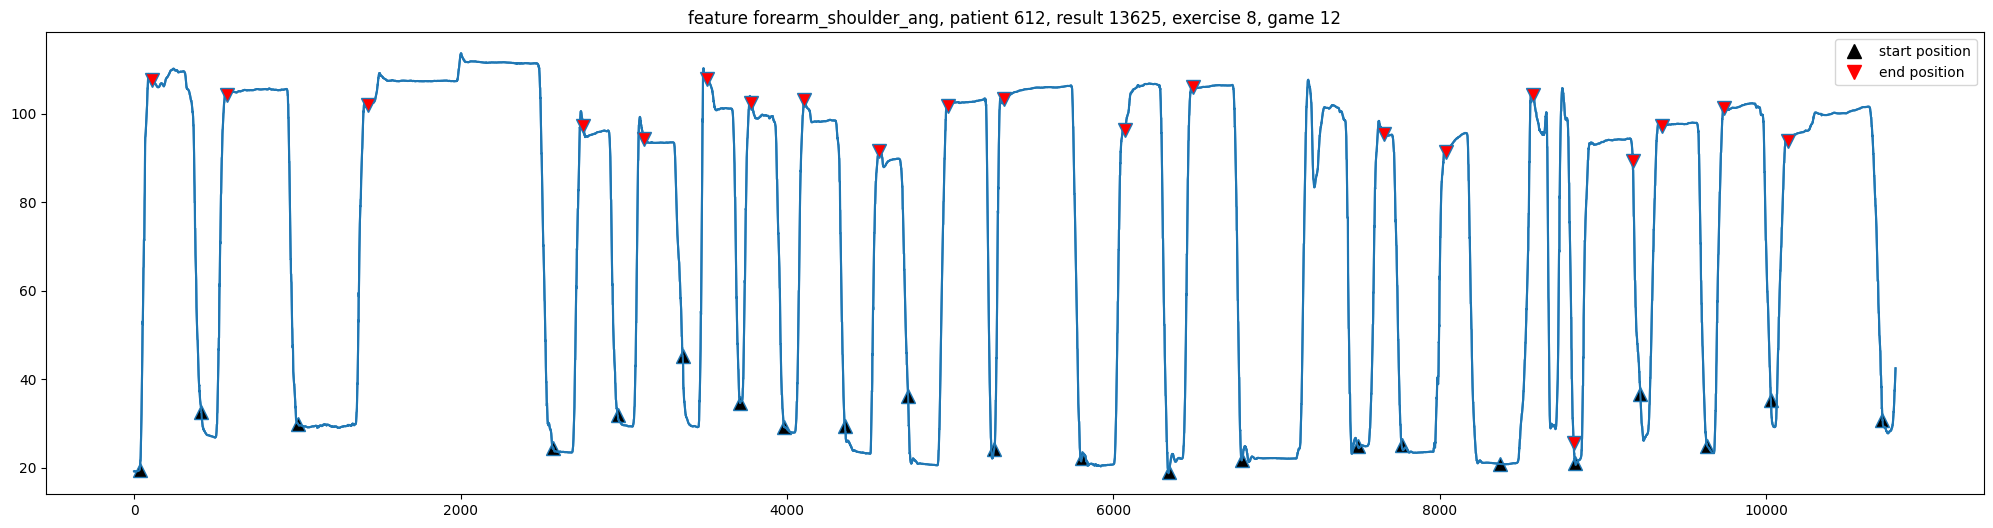

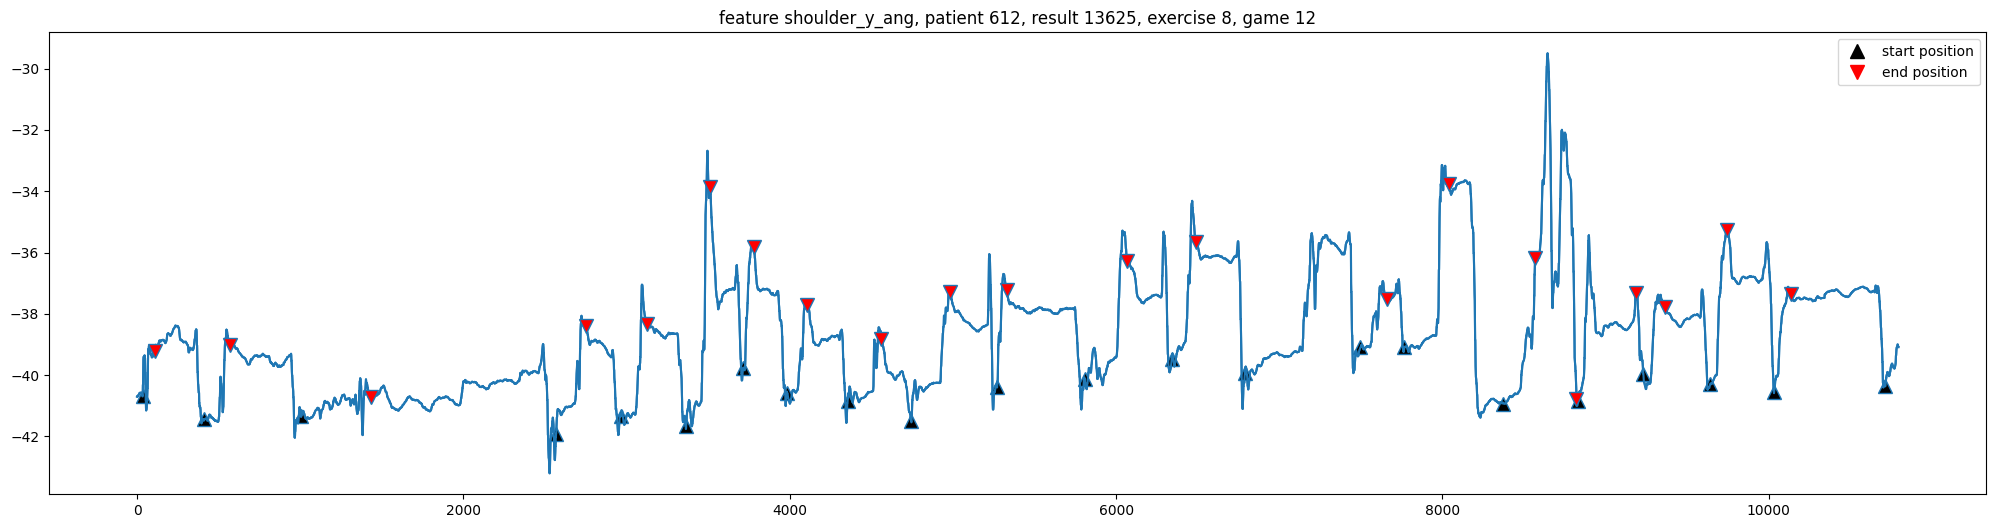

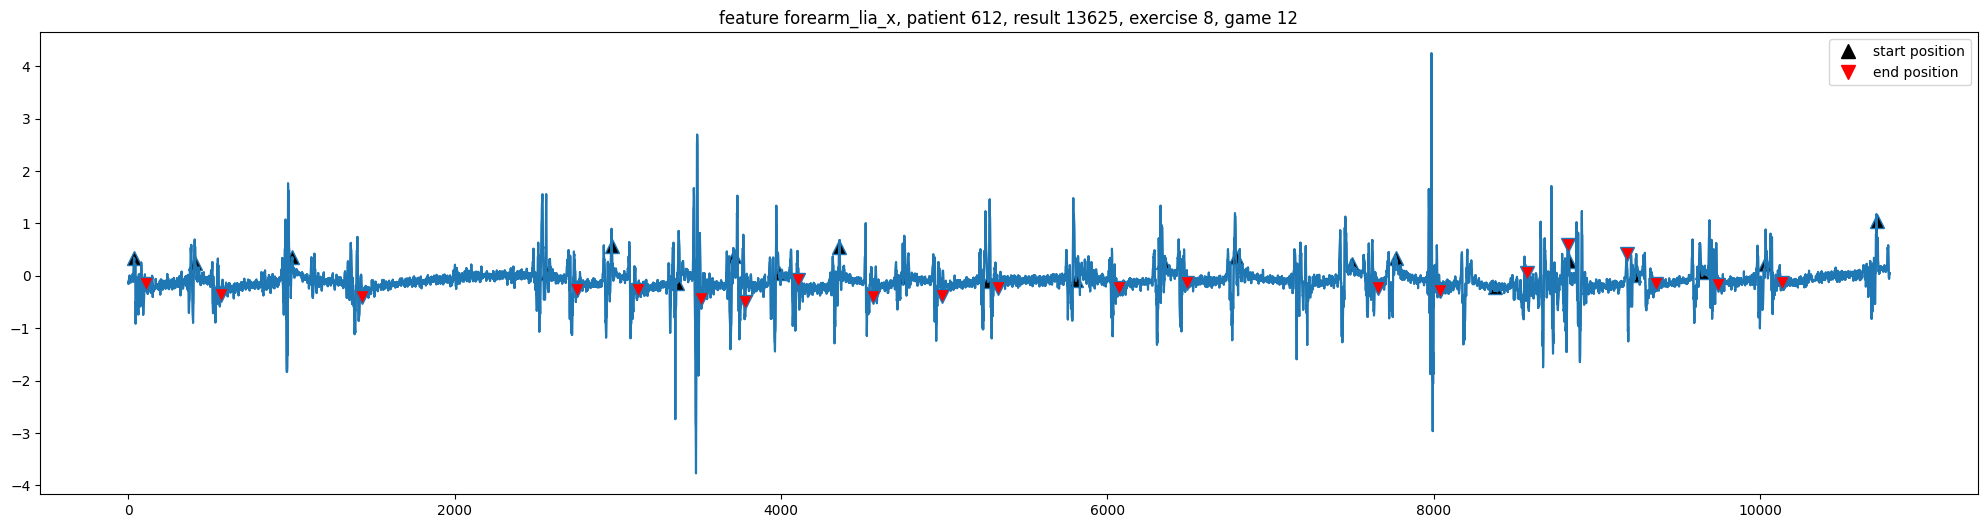

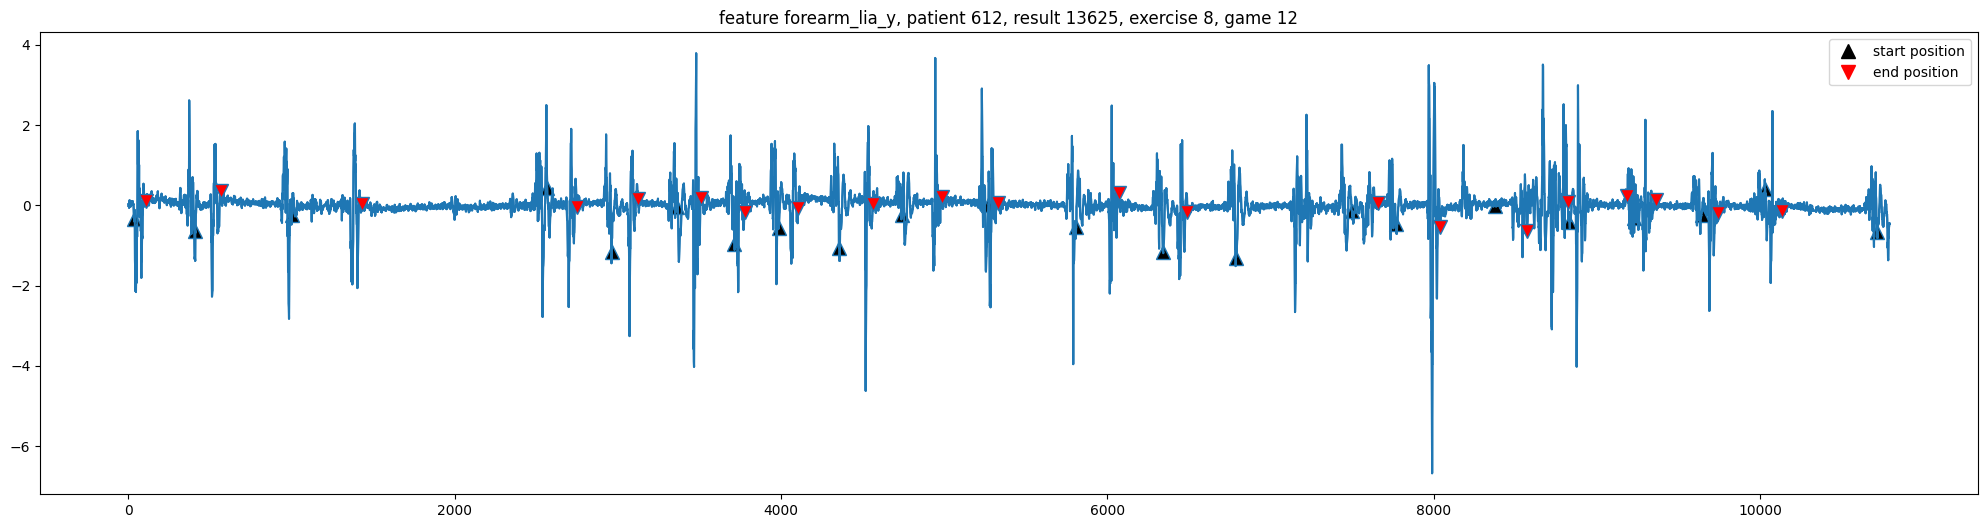

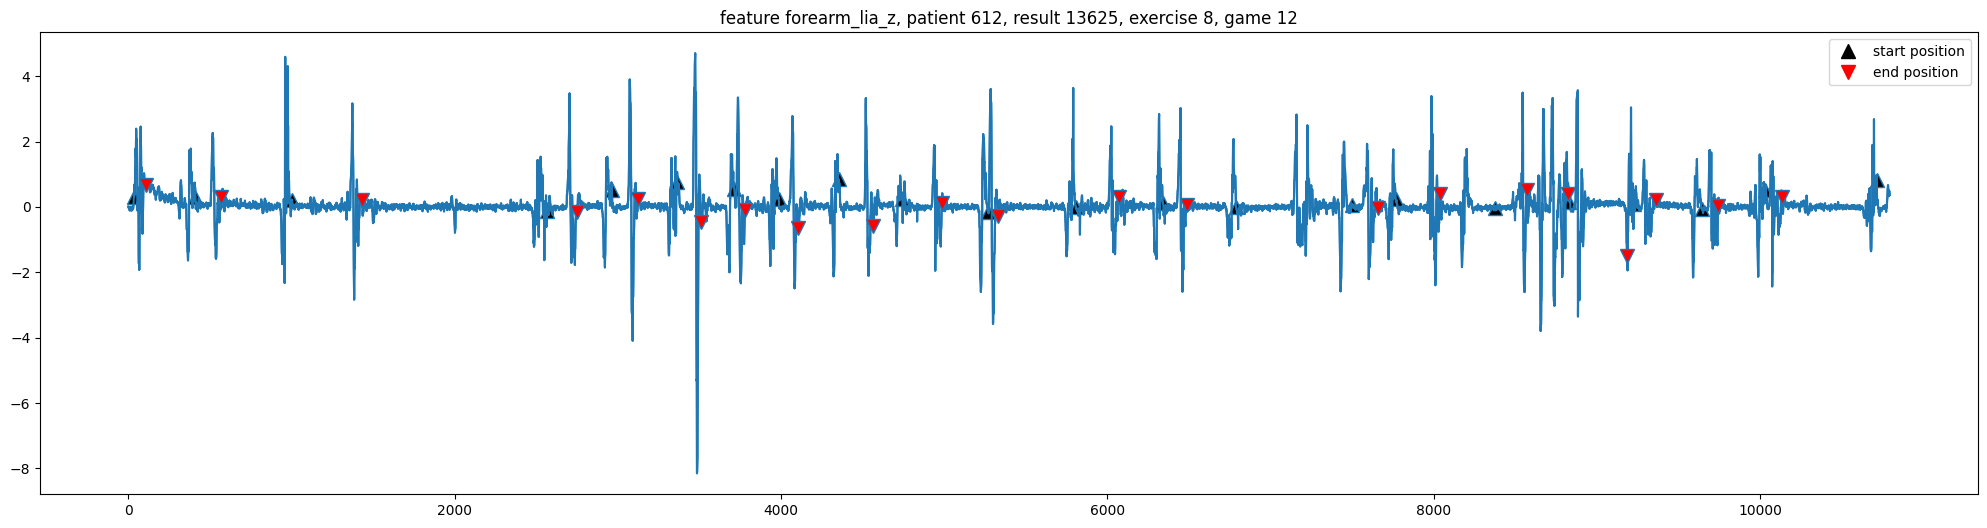

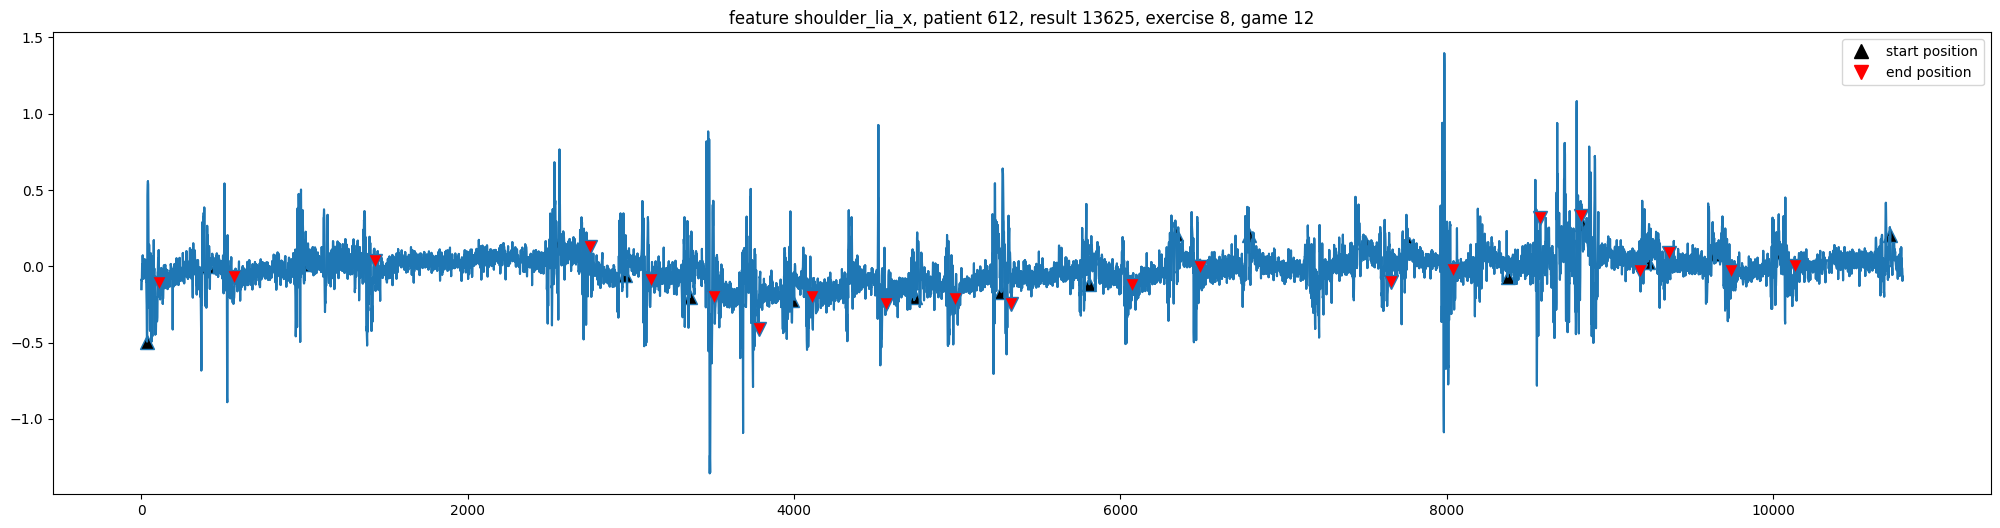

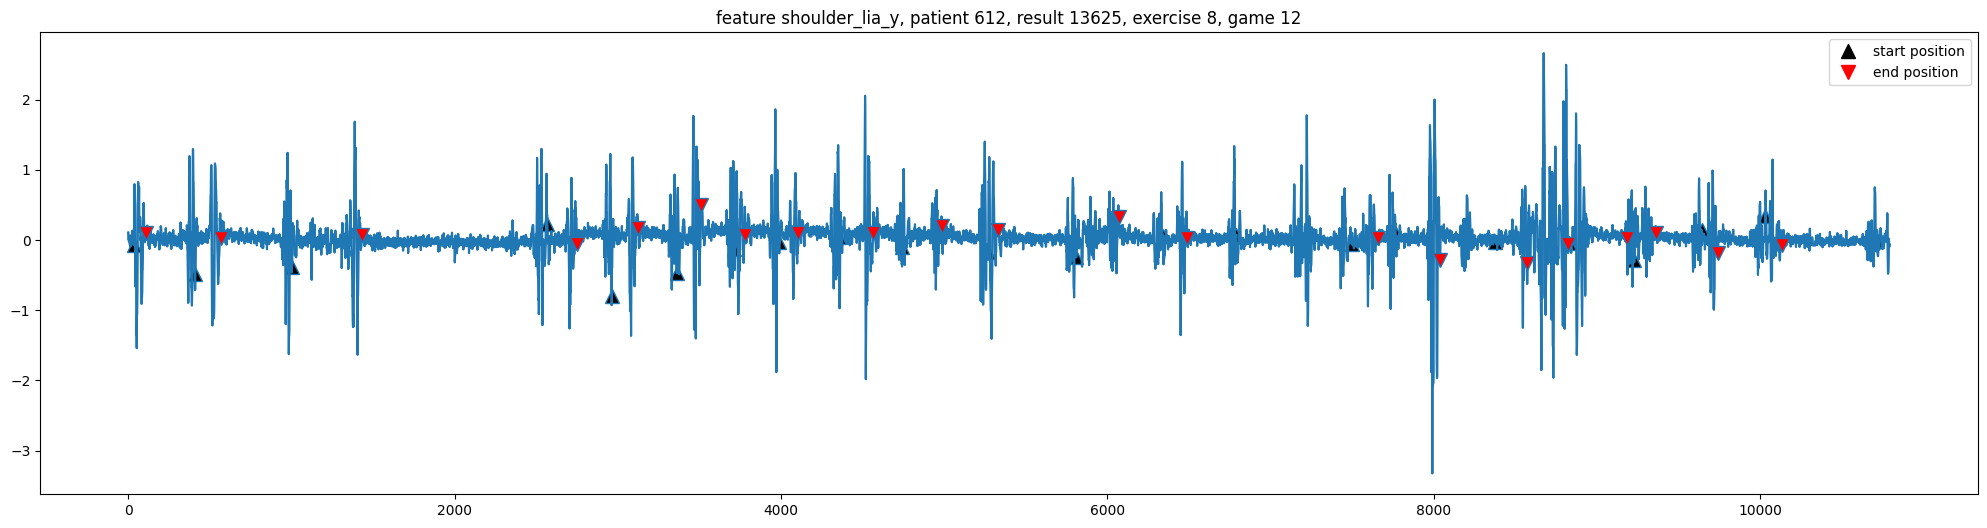

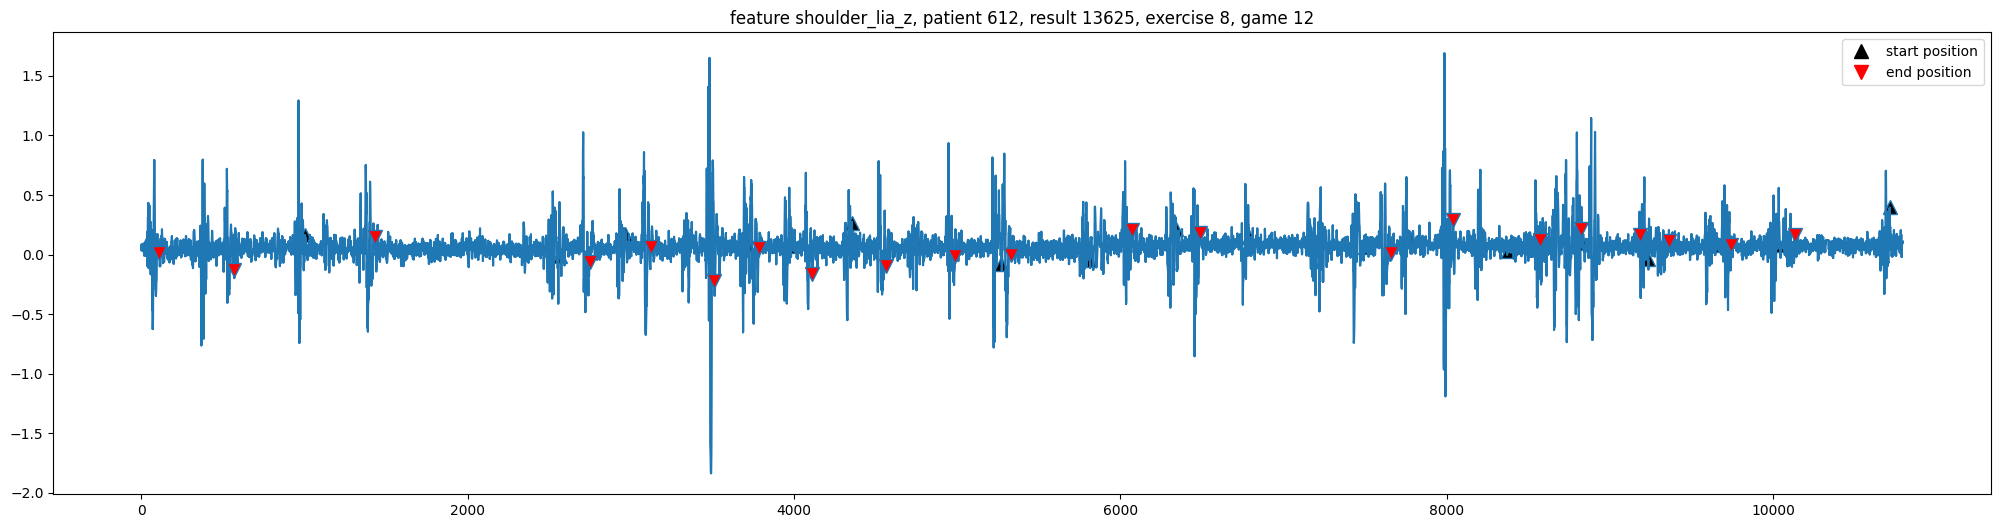

<Figure size 640x480 with 0 Axes>

In [22]:
plot_all_game_result_features(game_results_patient_1[0])

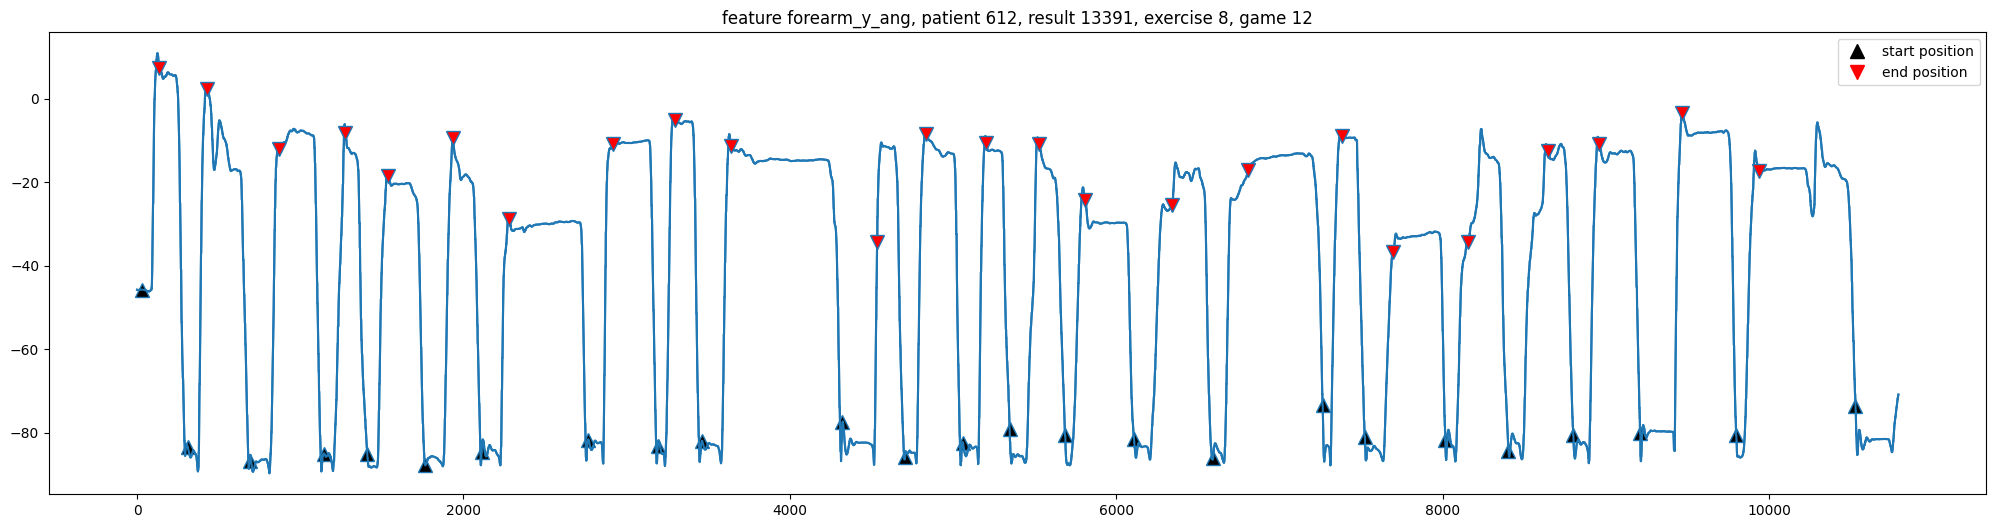

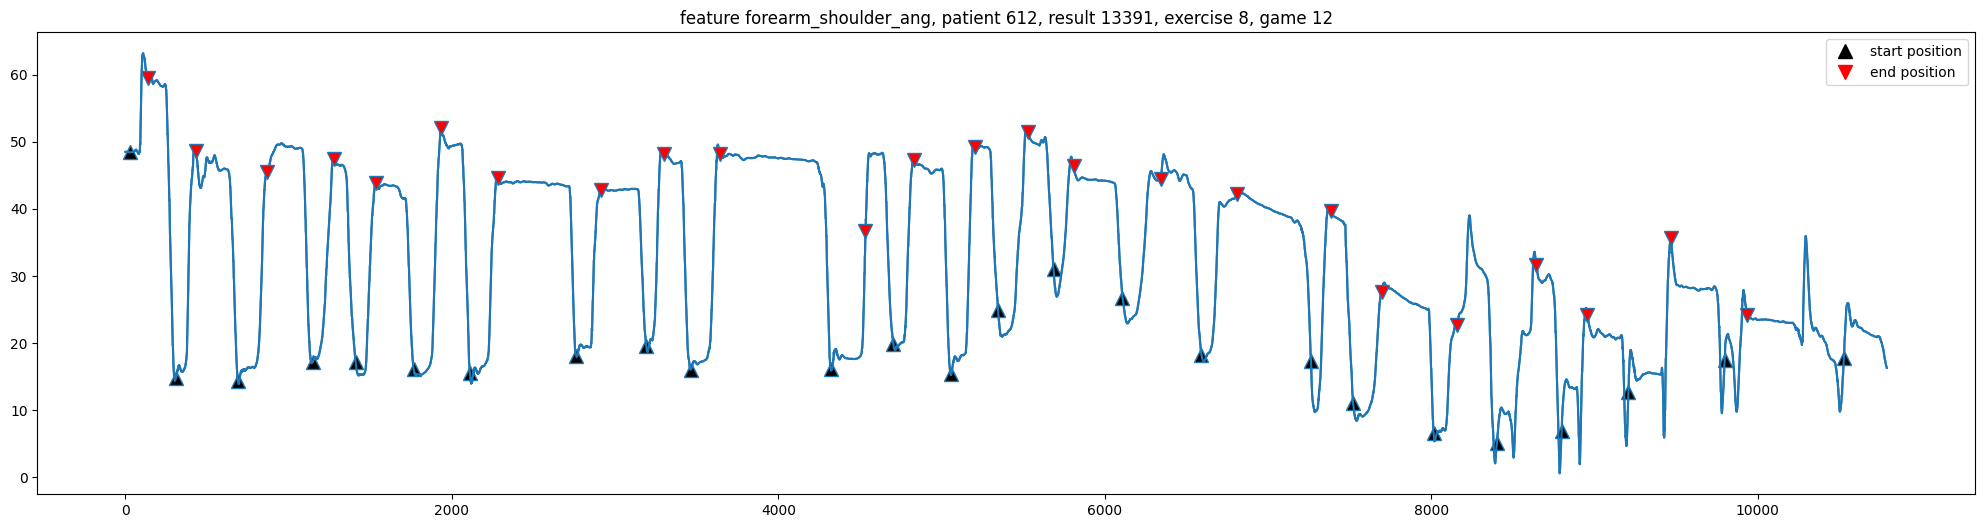

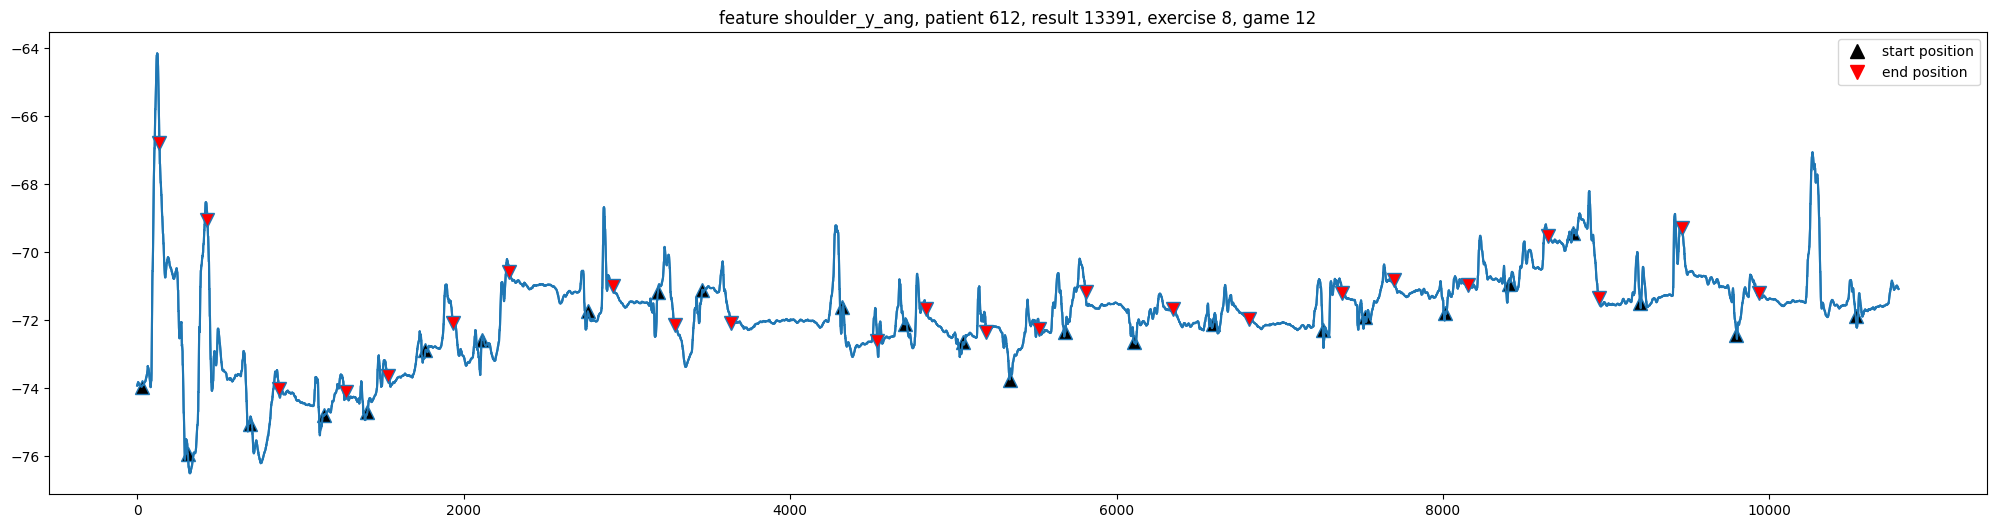

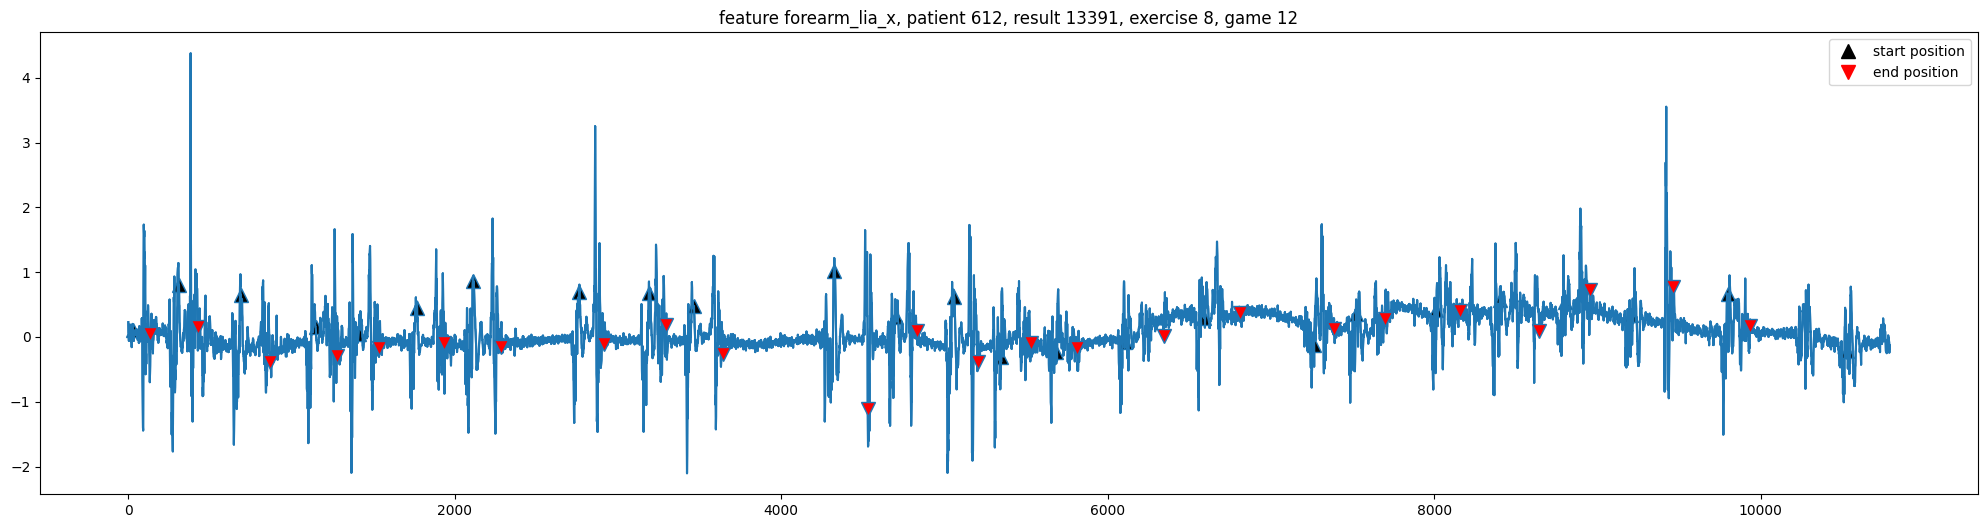

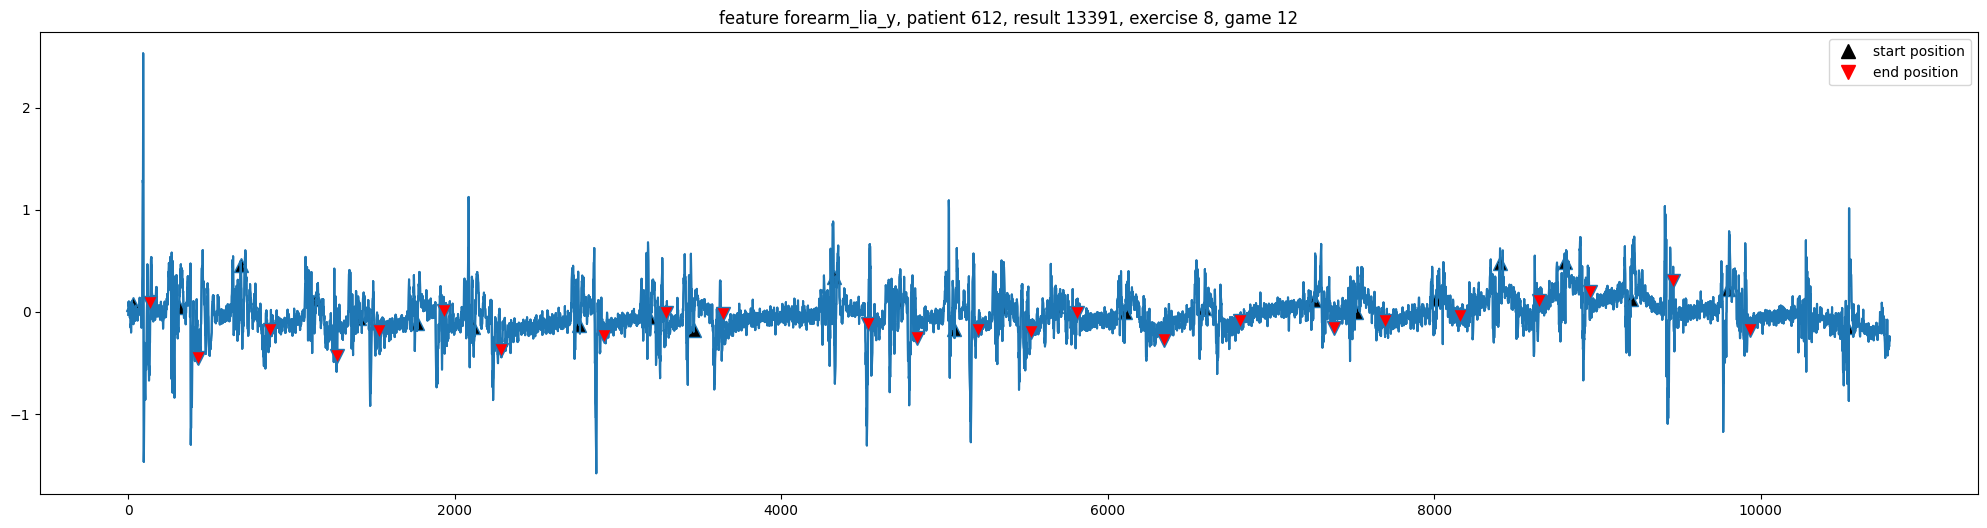

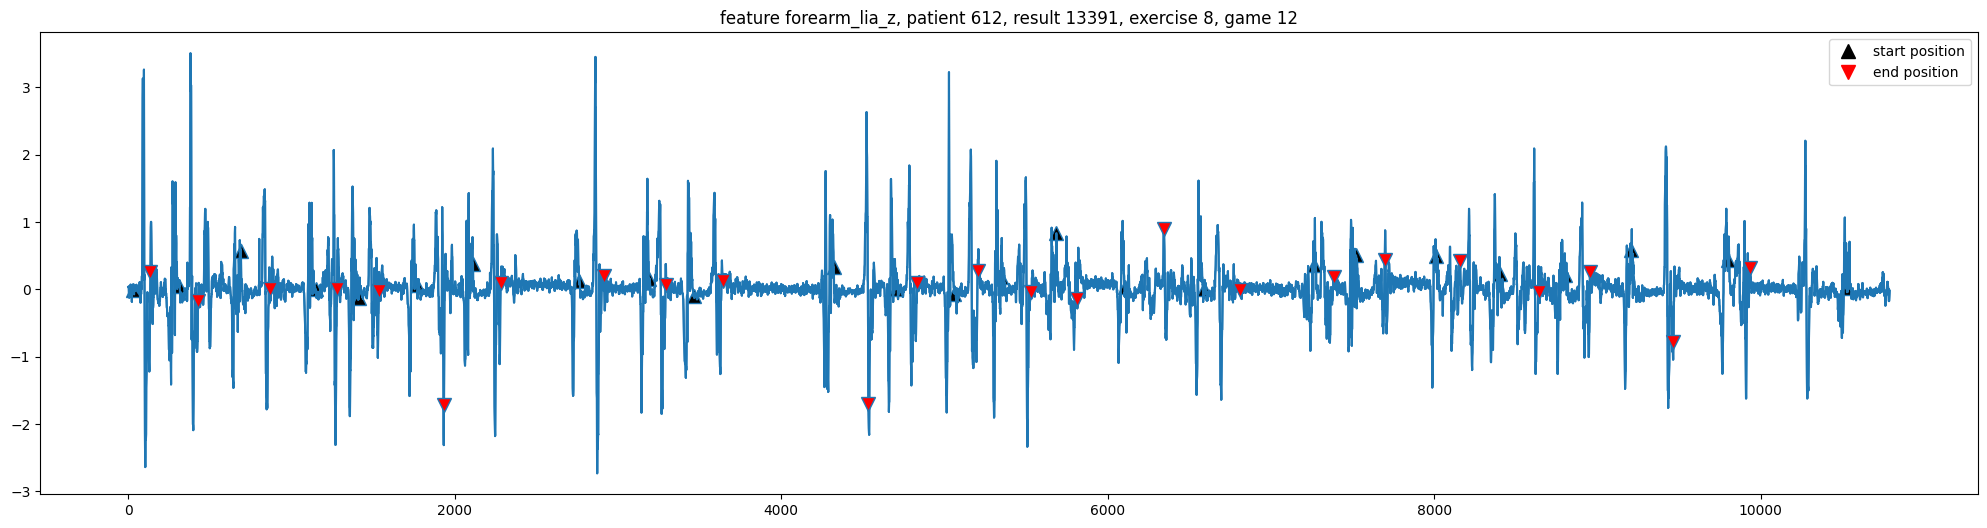

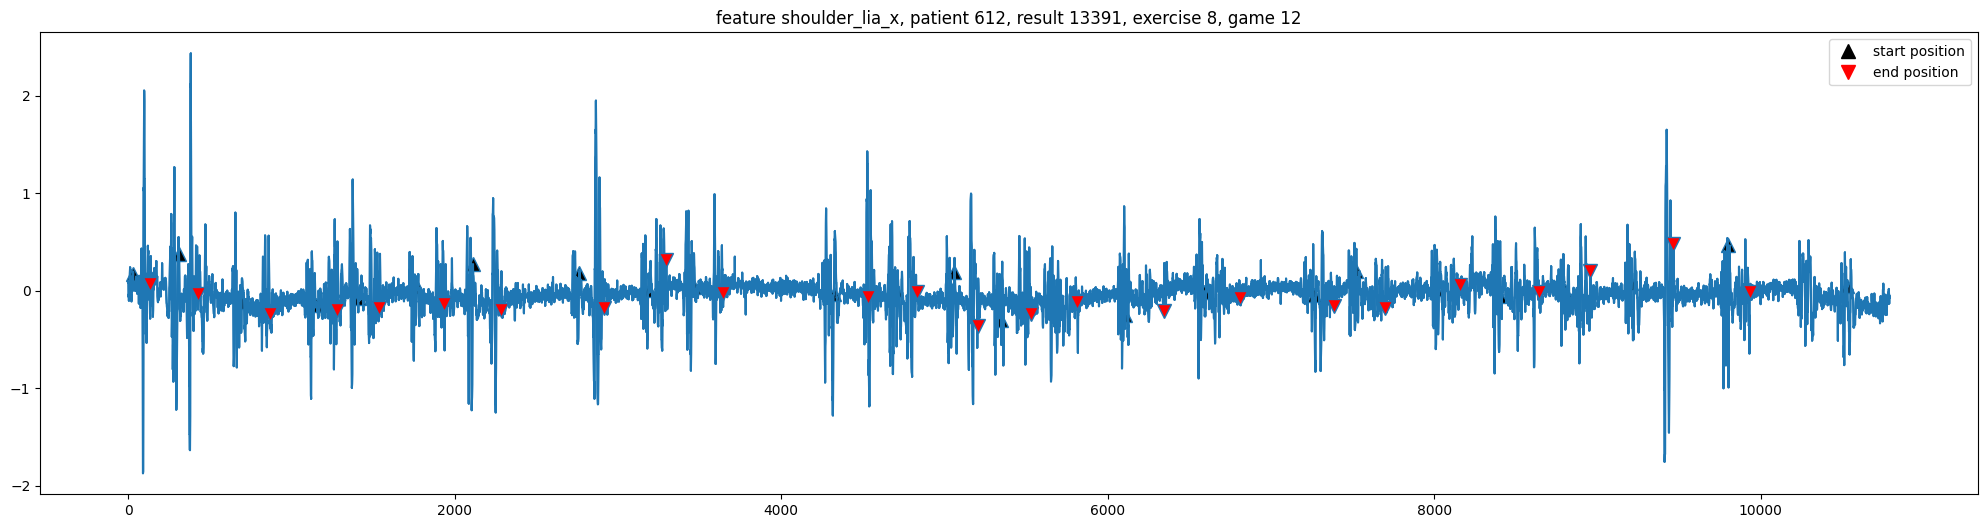

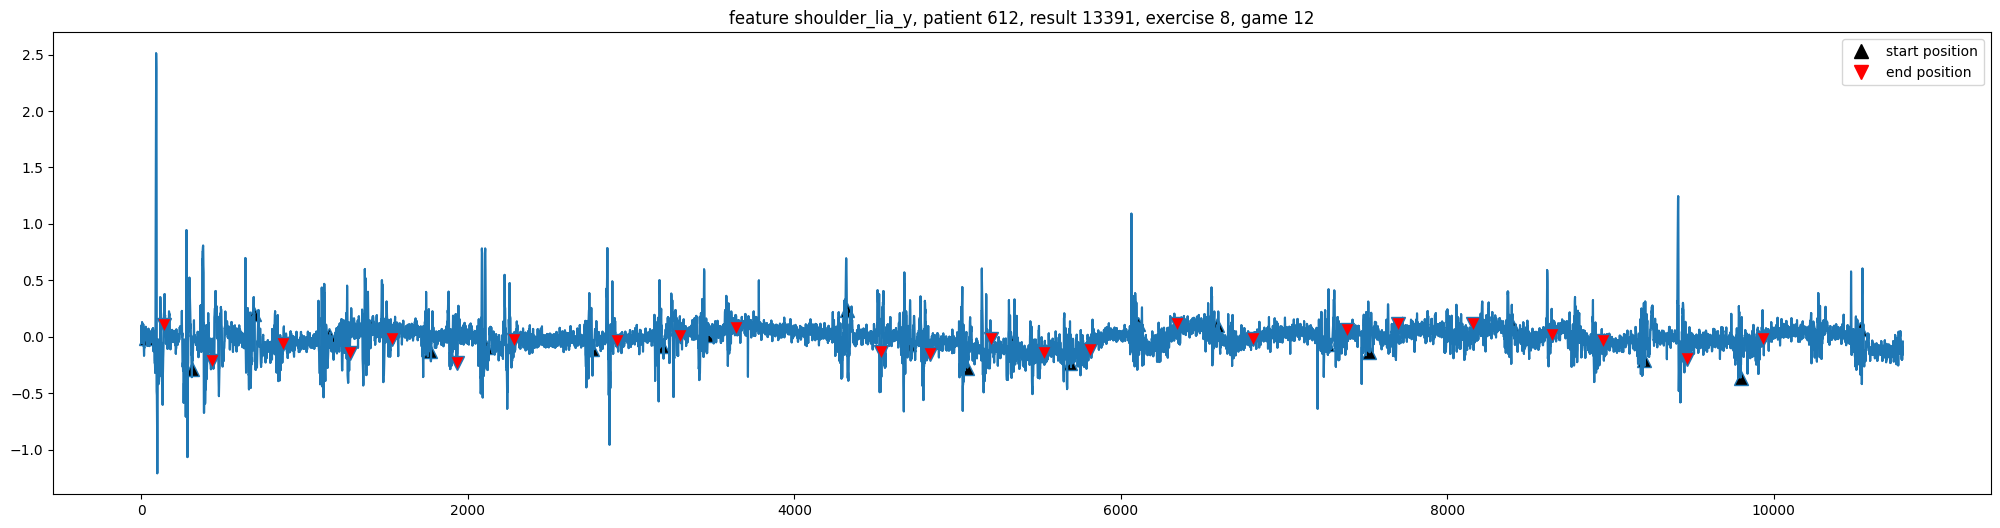

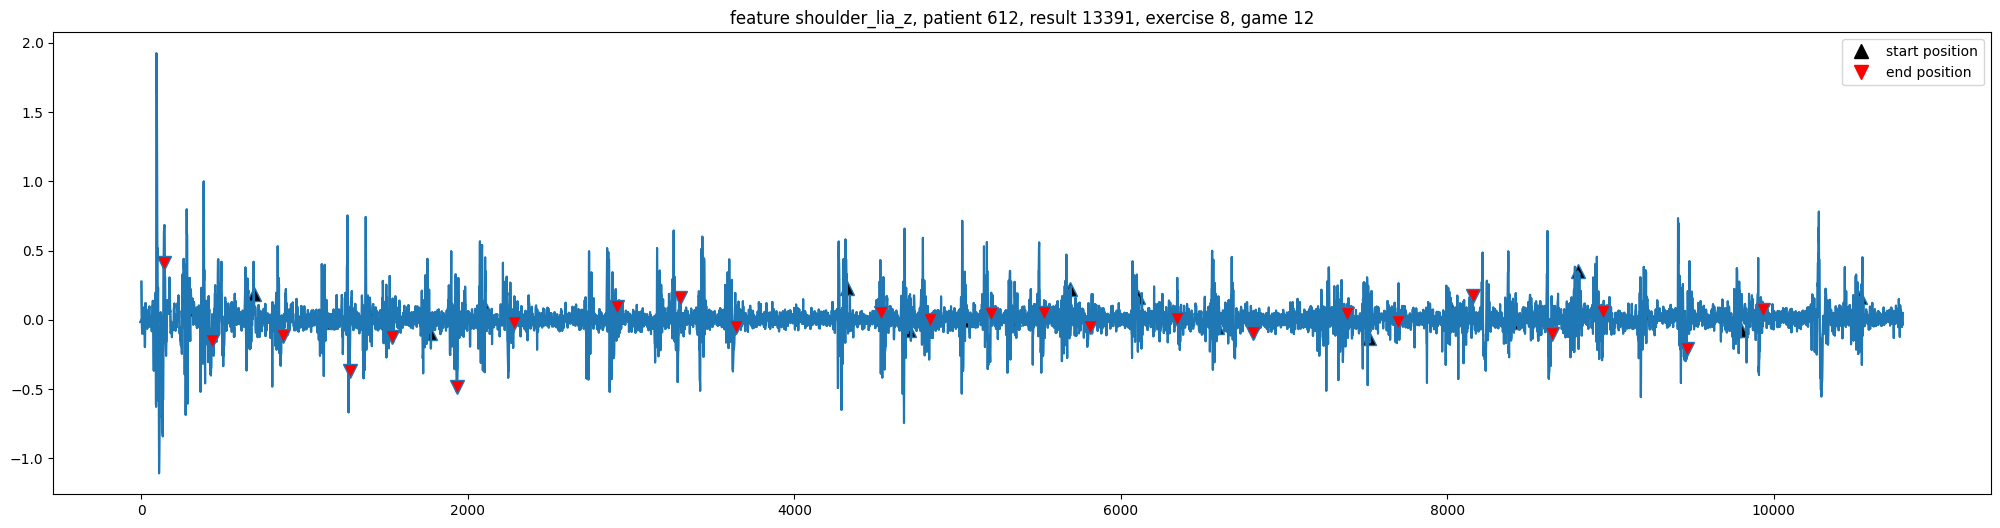

<Figure size 640x480 with 0 Axes>

In [23]:
plot_all_game_result_features(game_results_patient_1[1])

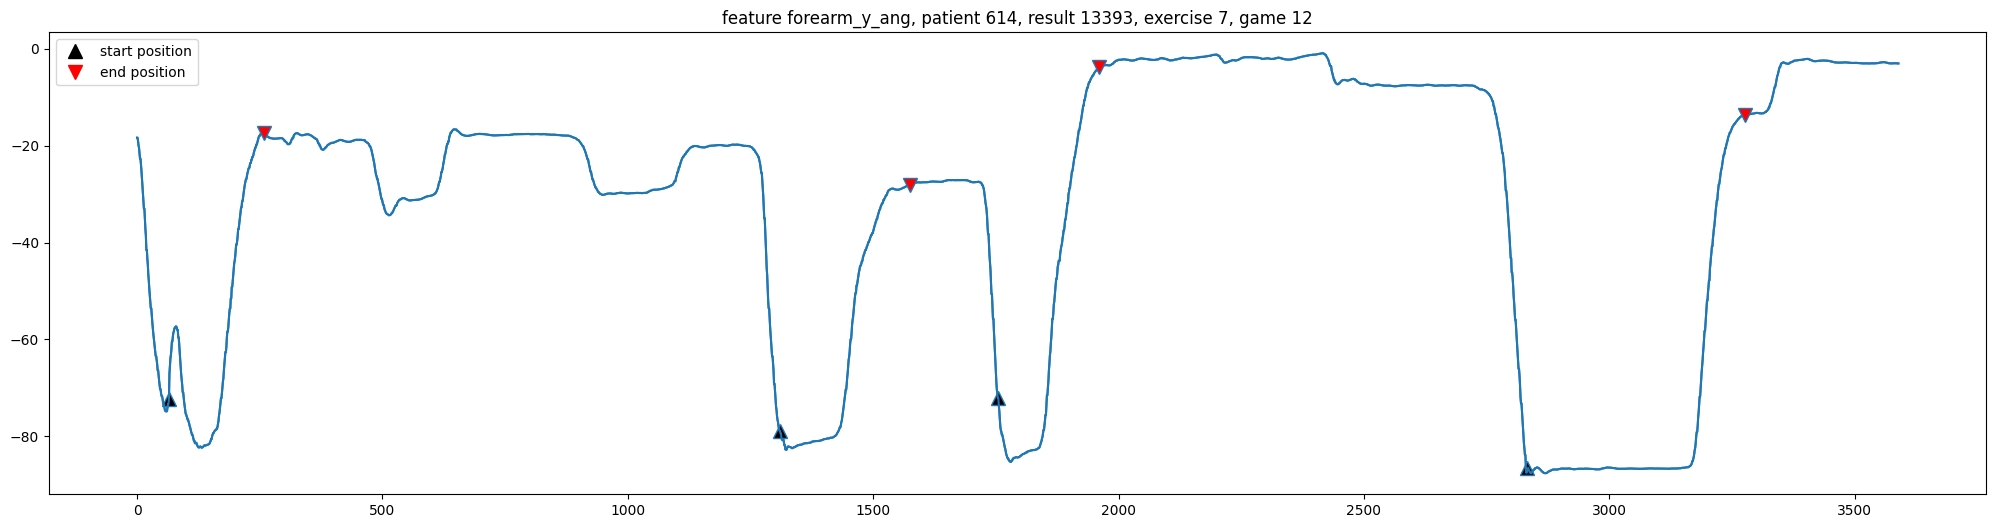

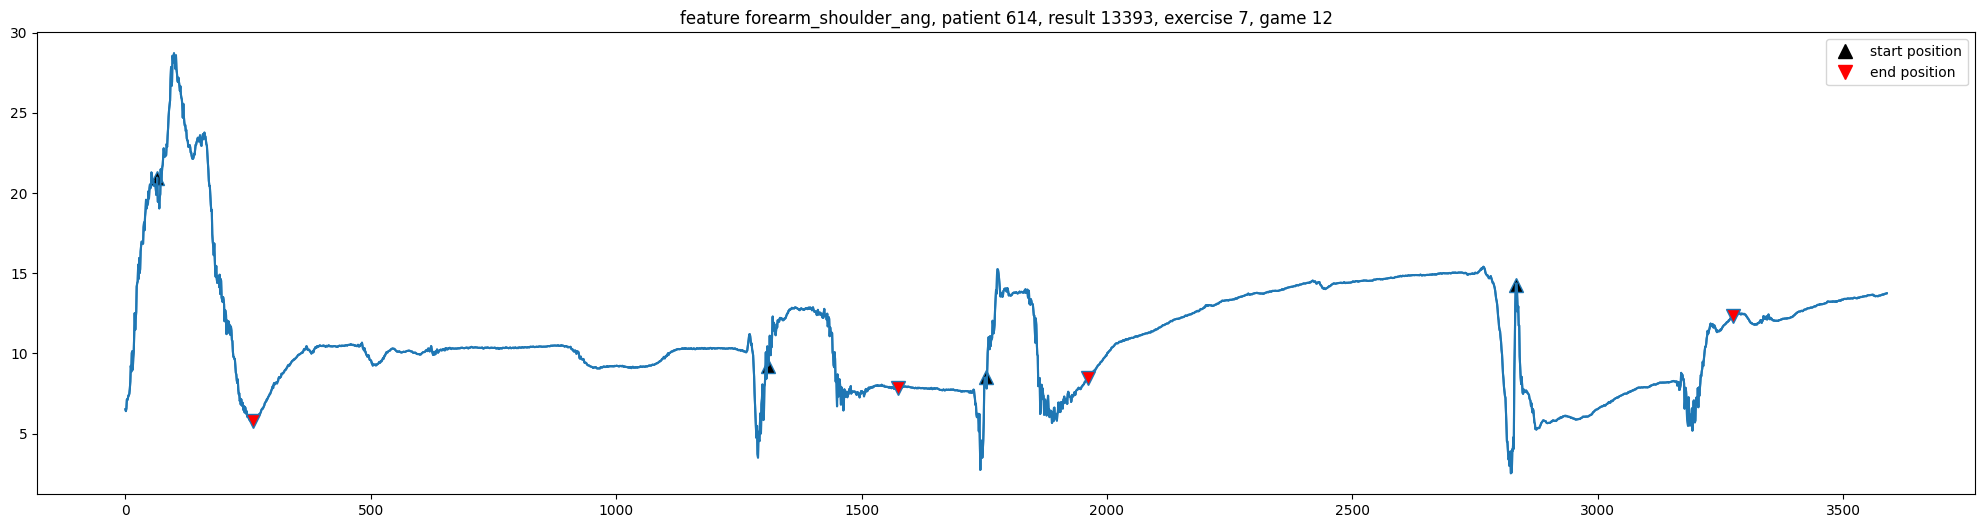

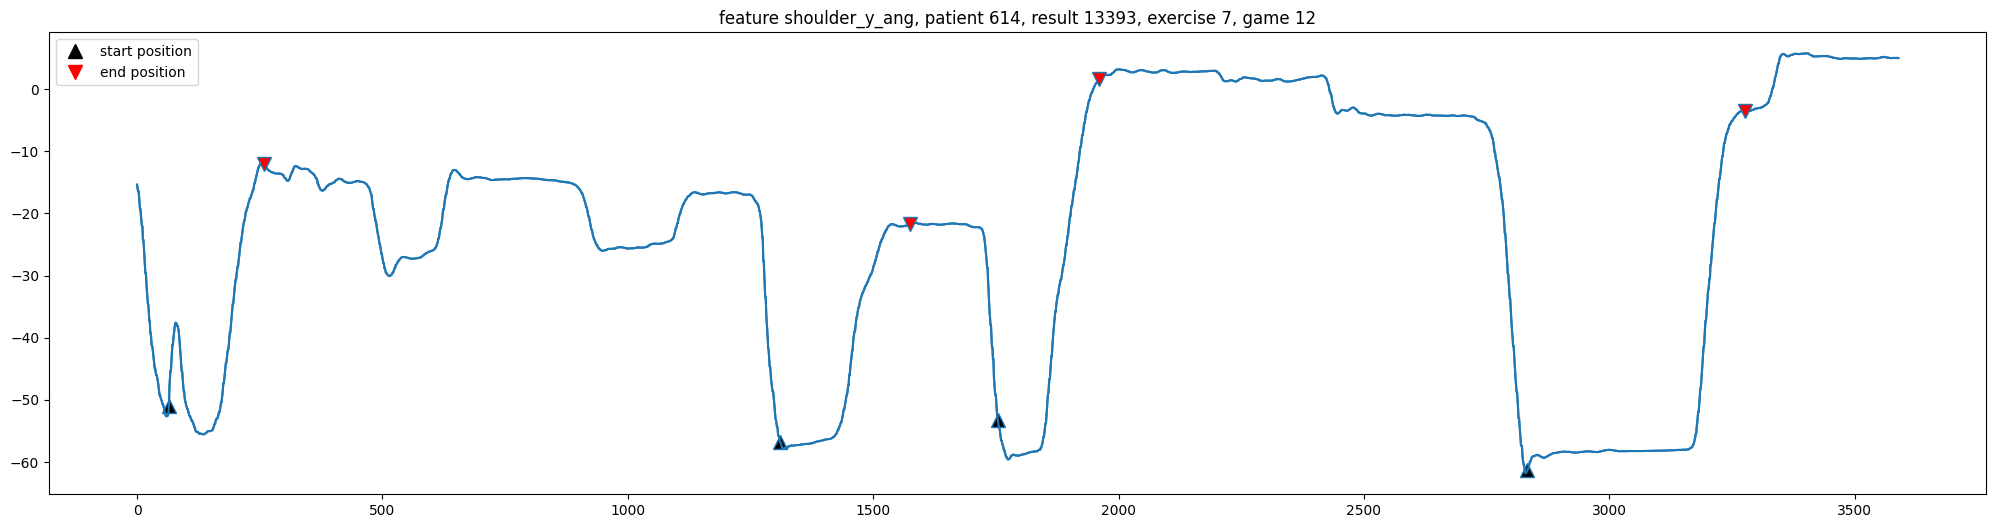

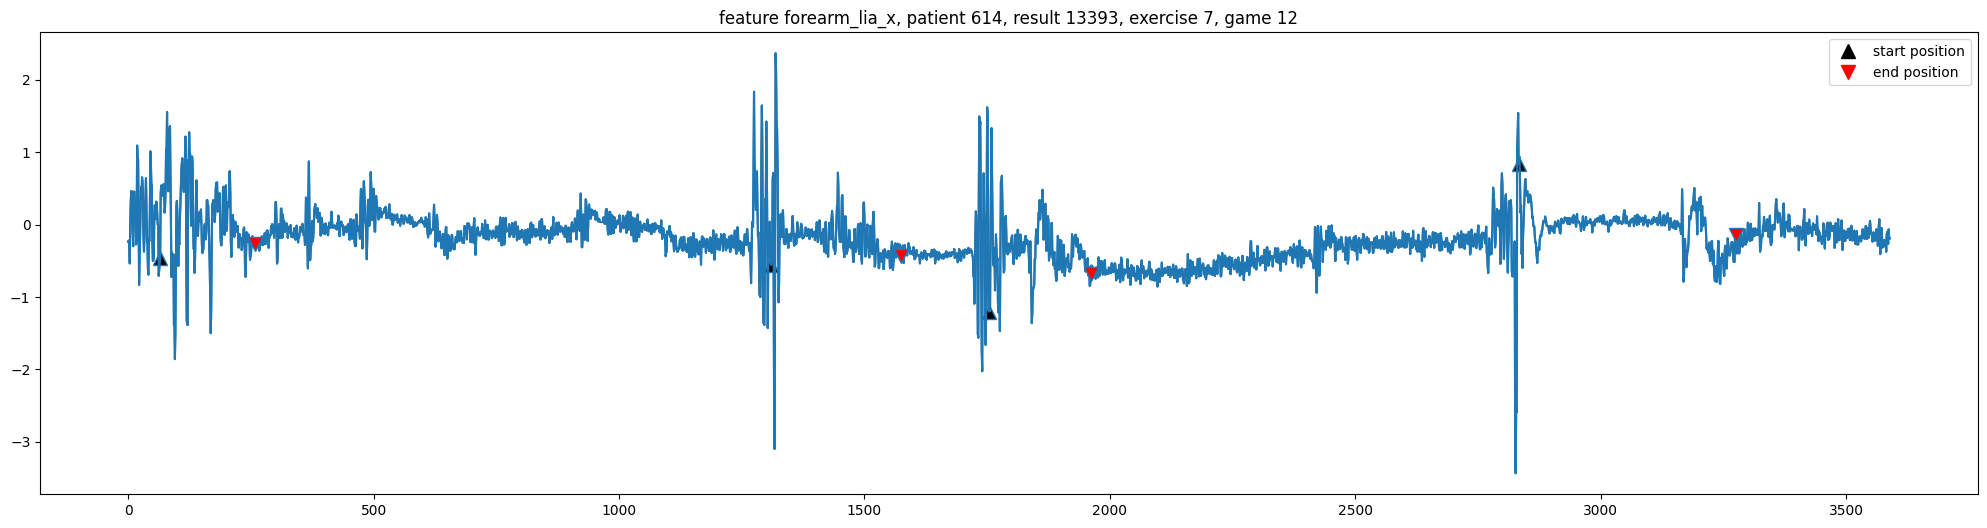

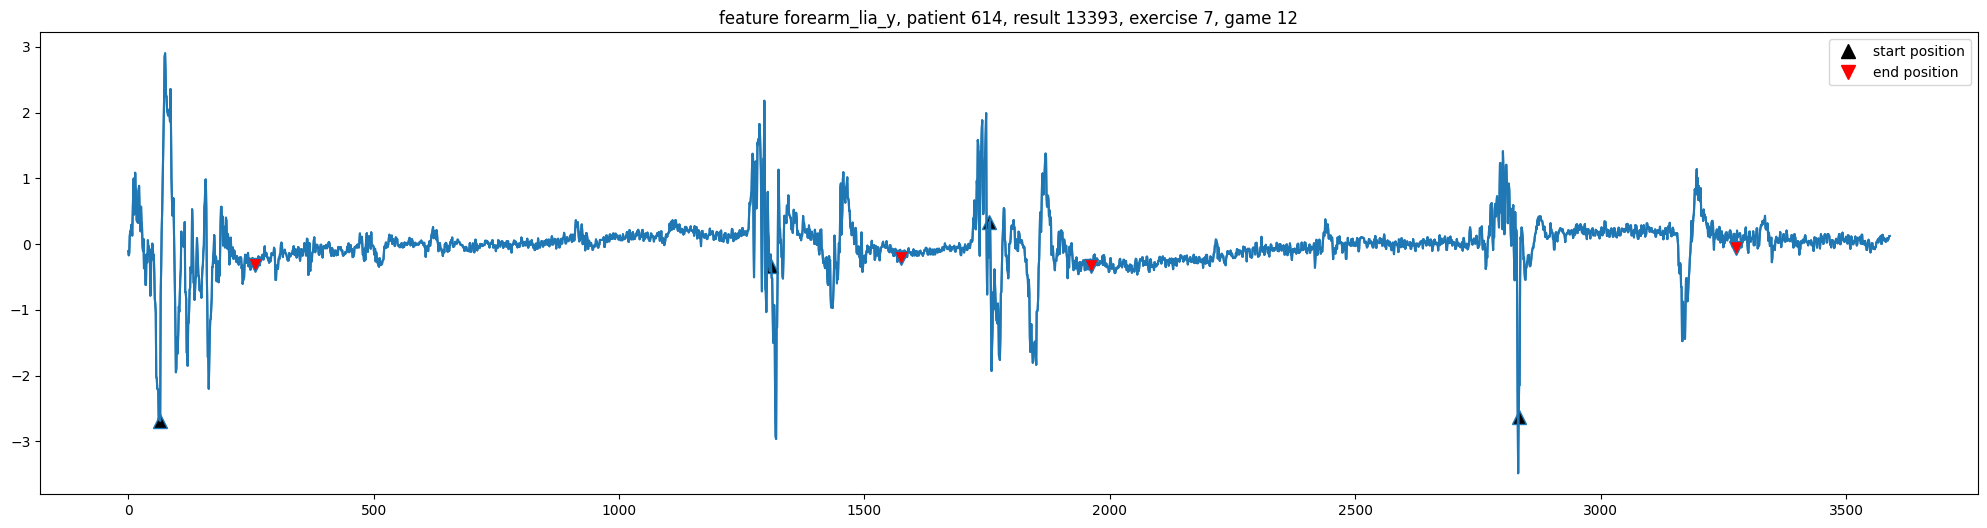

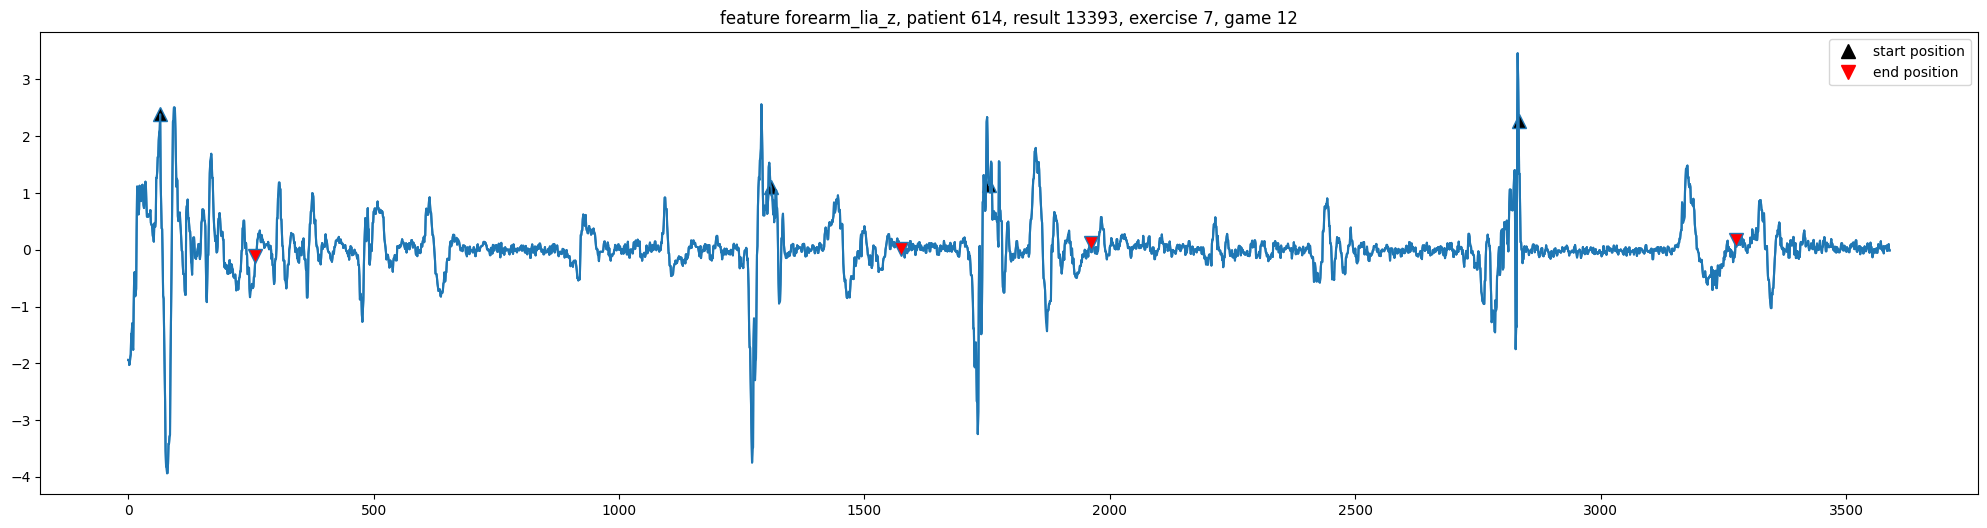

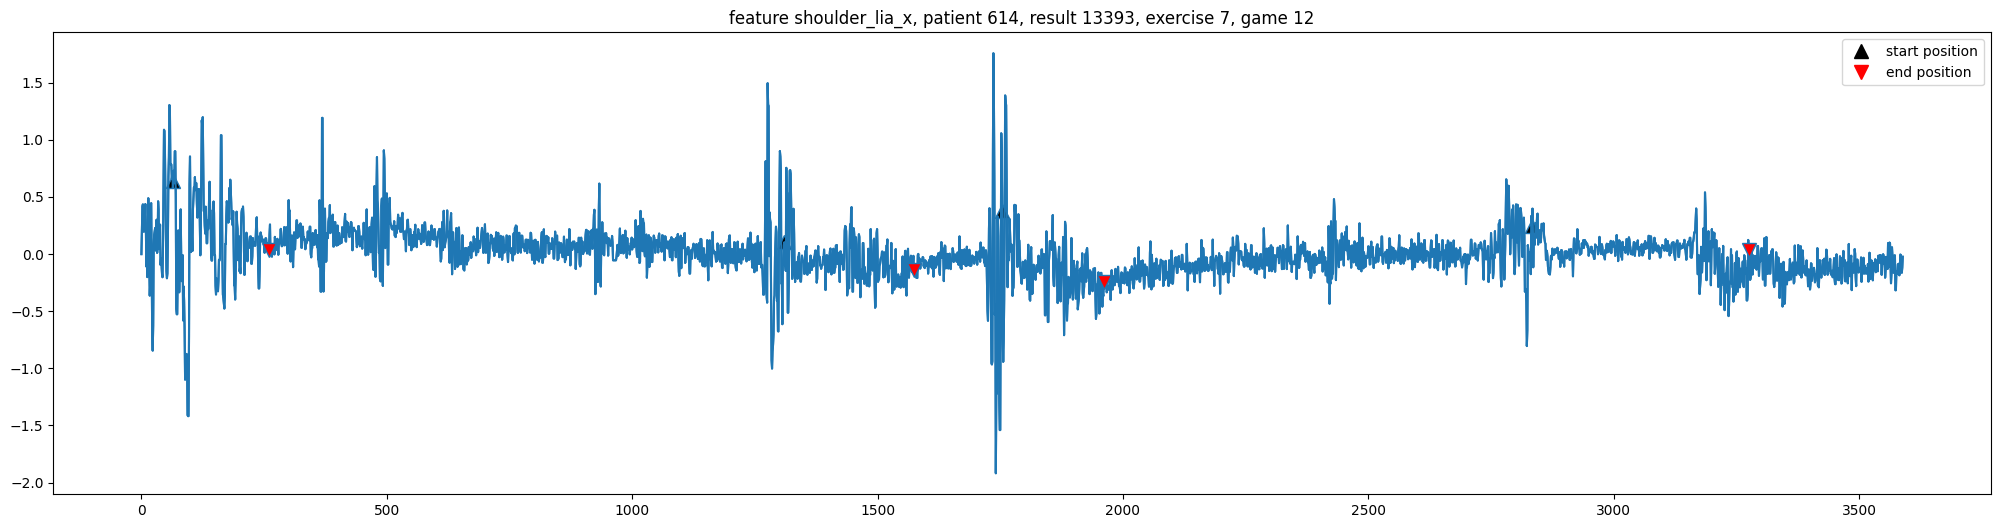

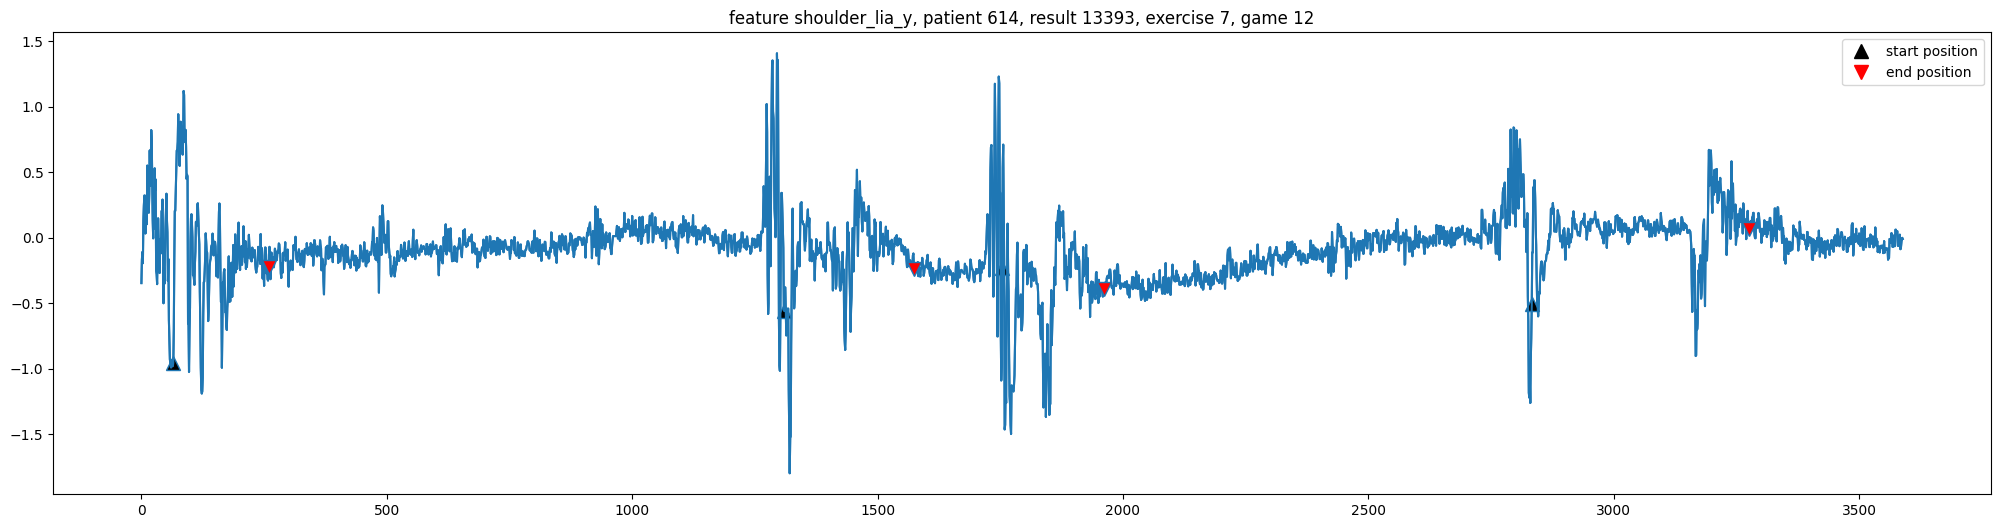

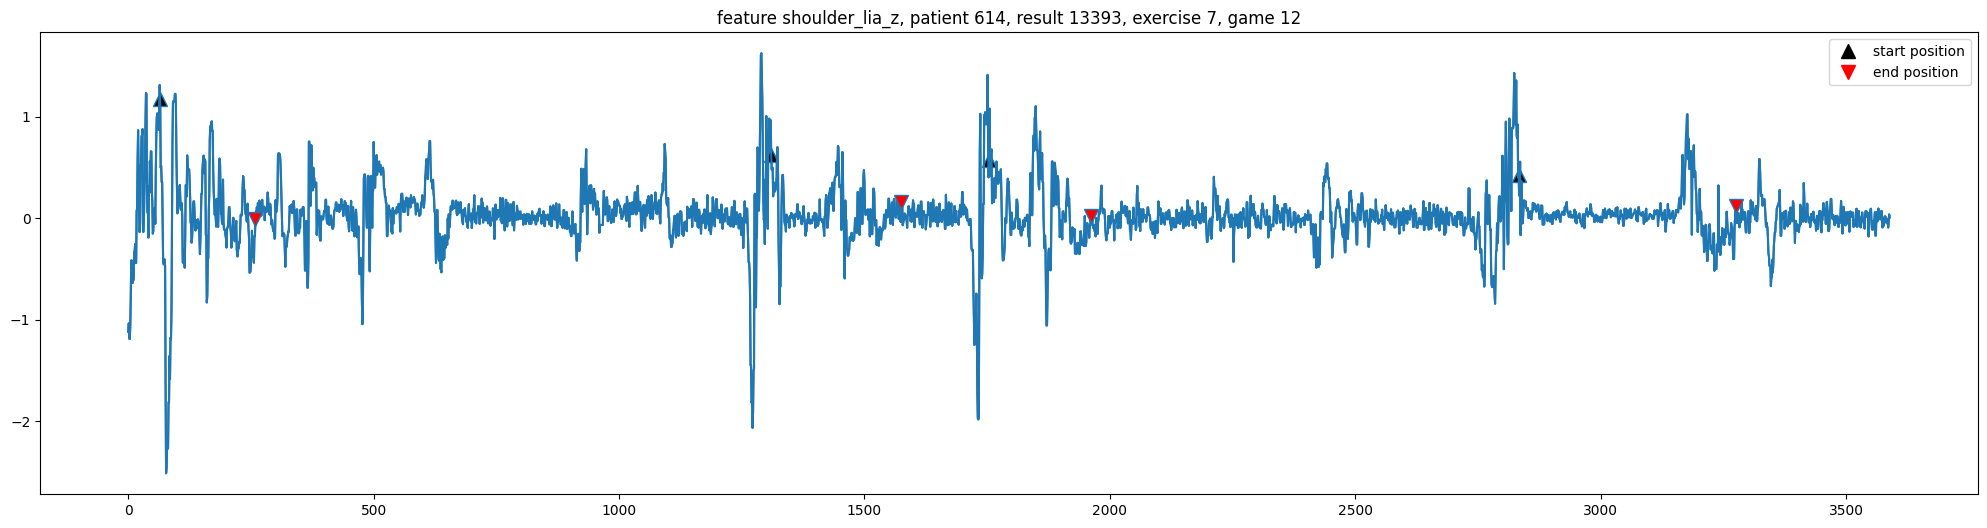

<Figure size 640x480 with 0 Axes>

In [24]:
plot_all_game_result_features(game_results_patient_2[0])

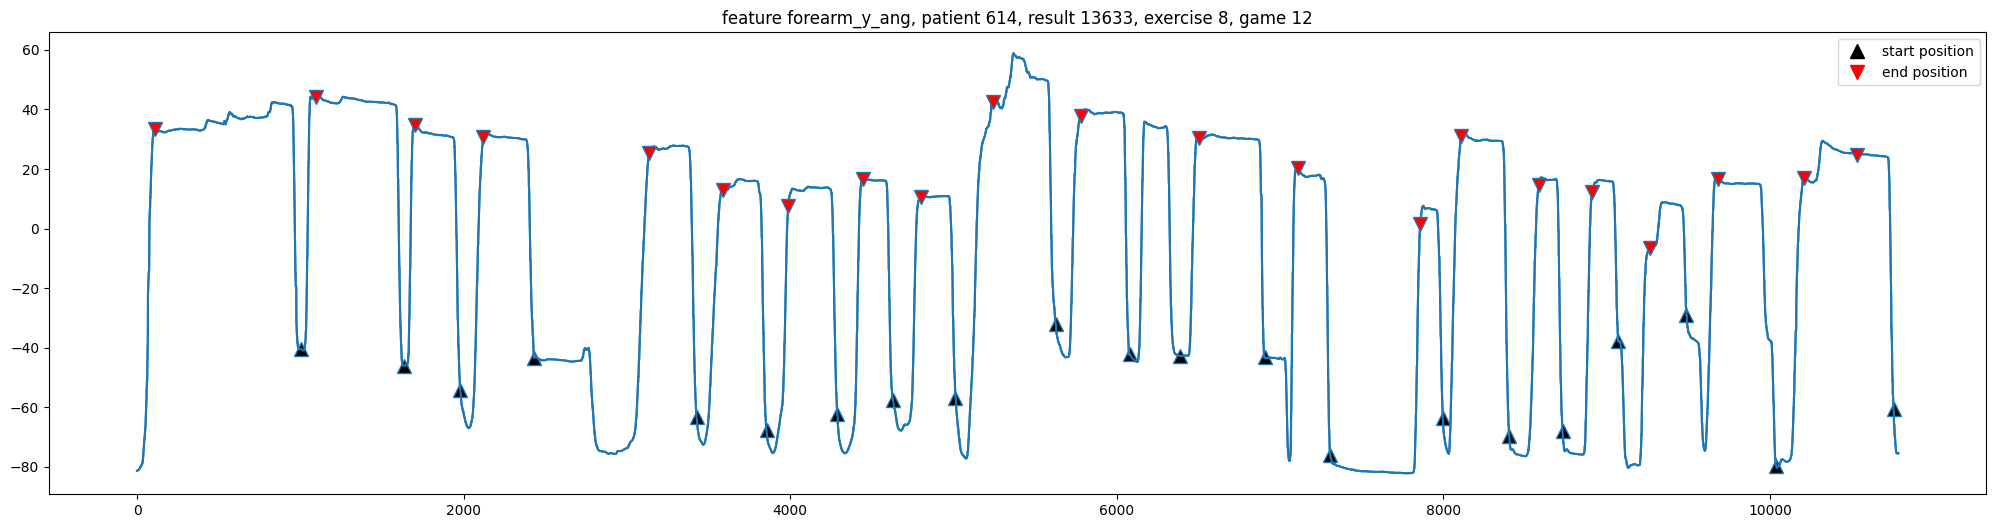

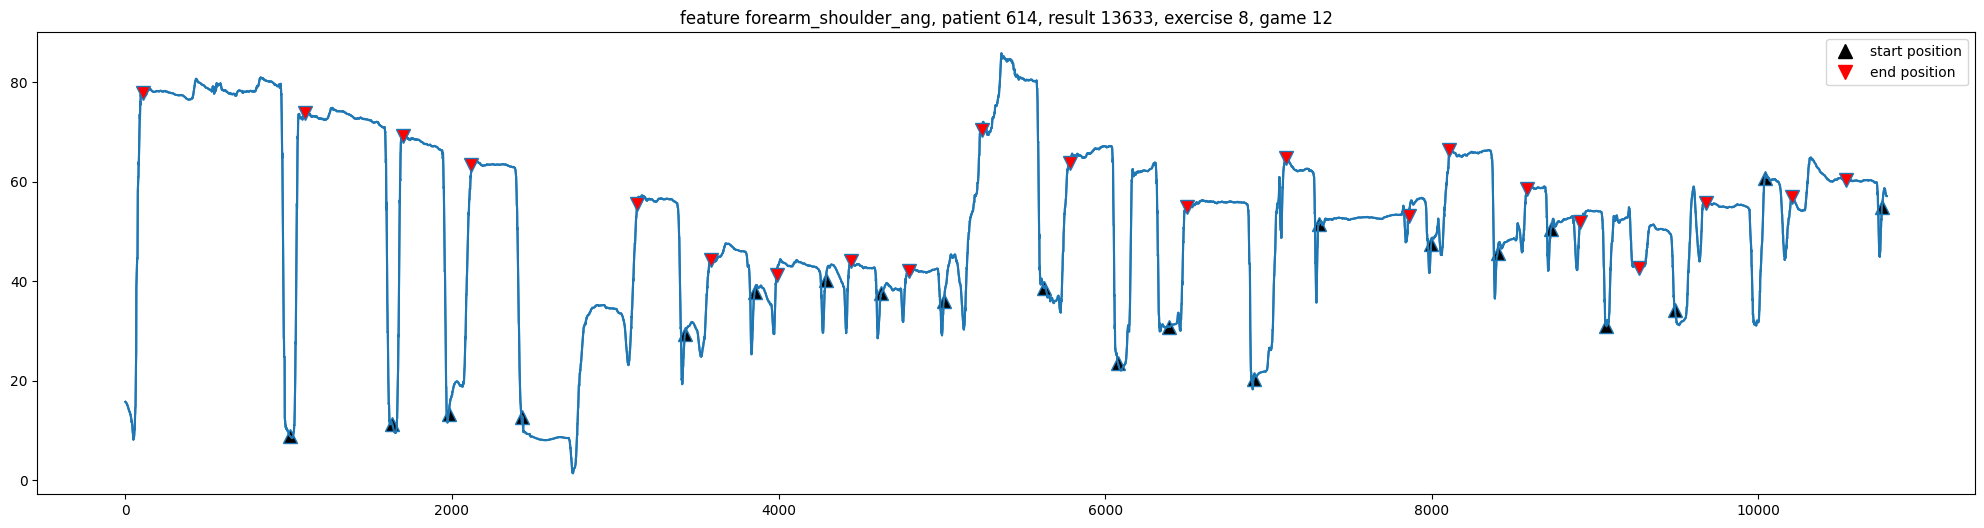

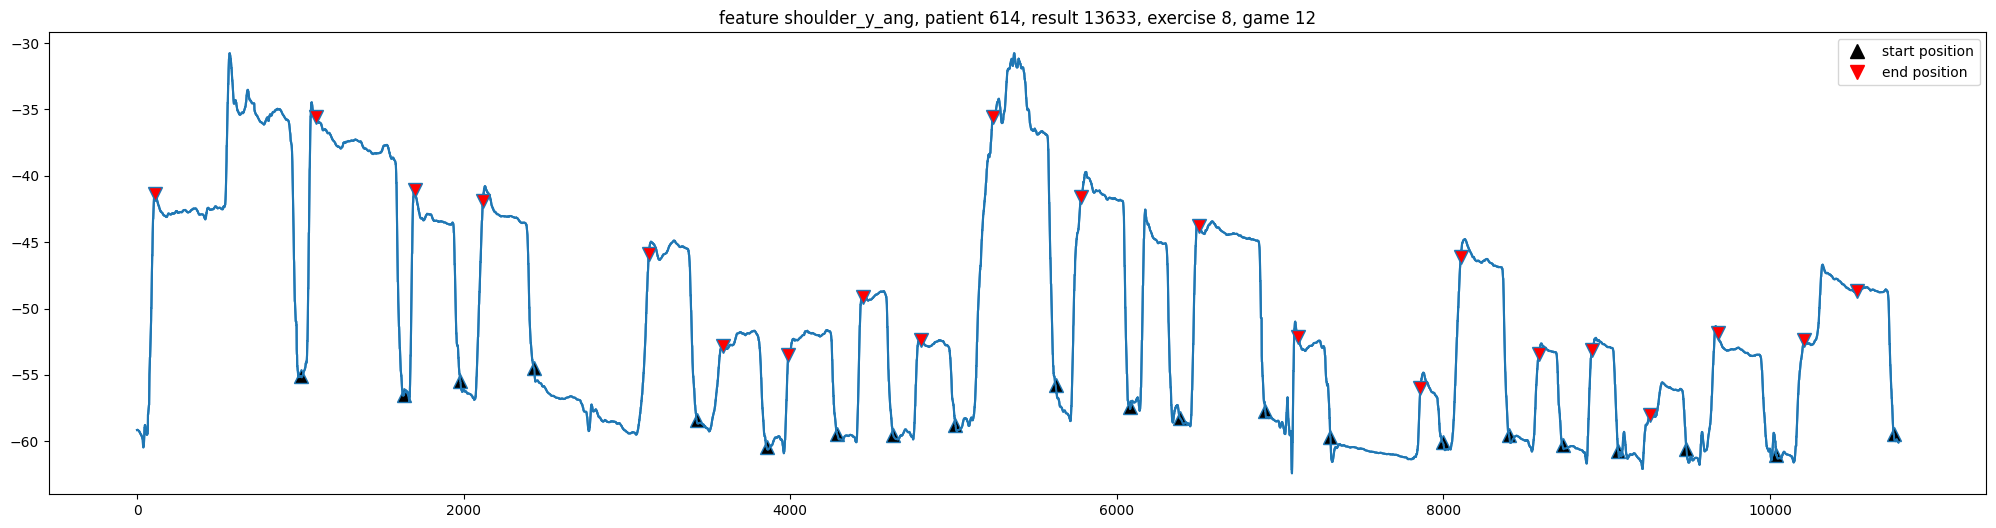

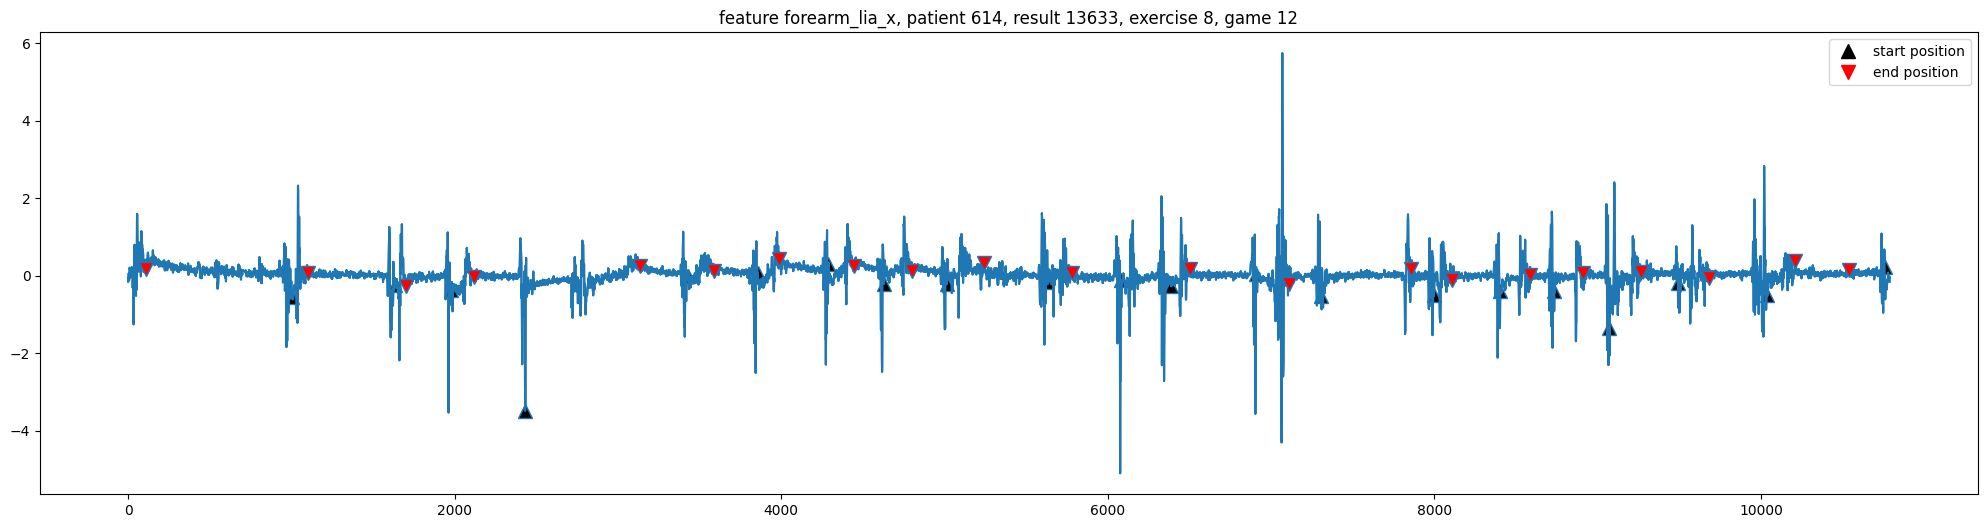

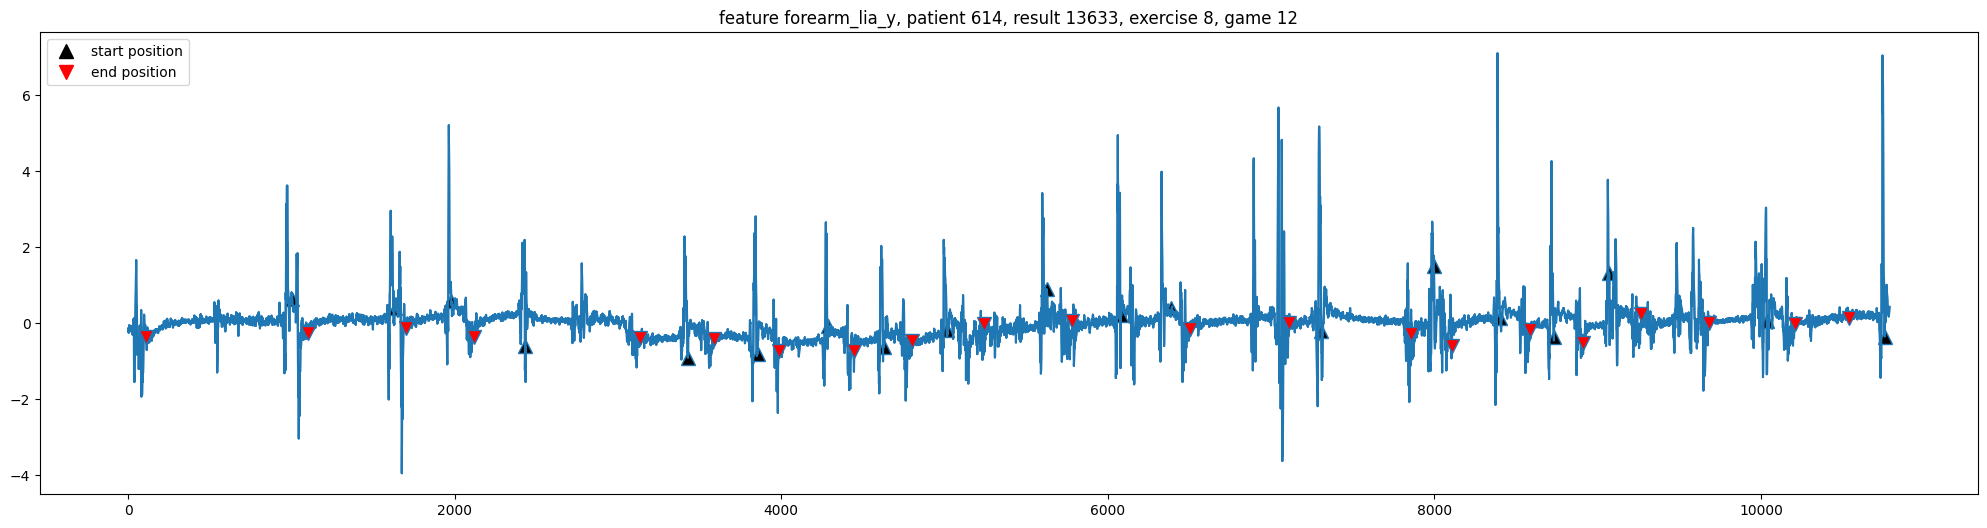

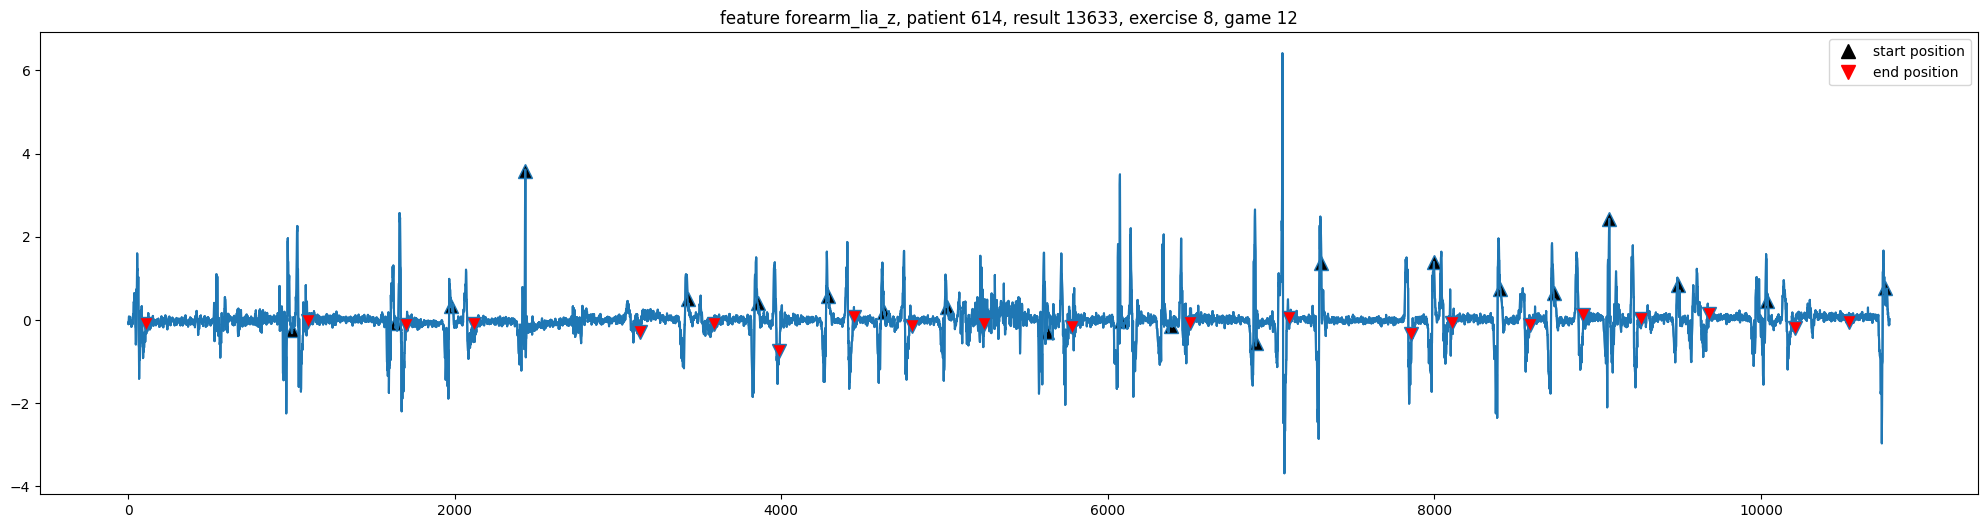

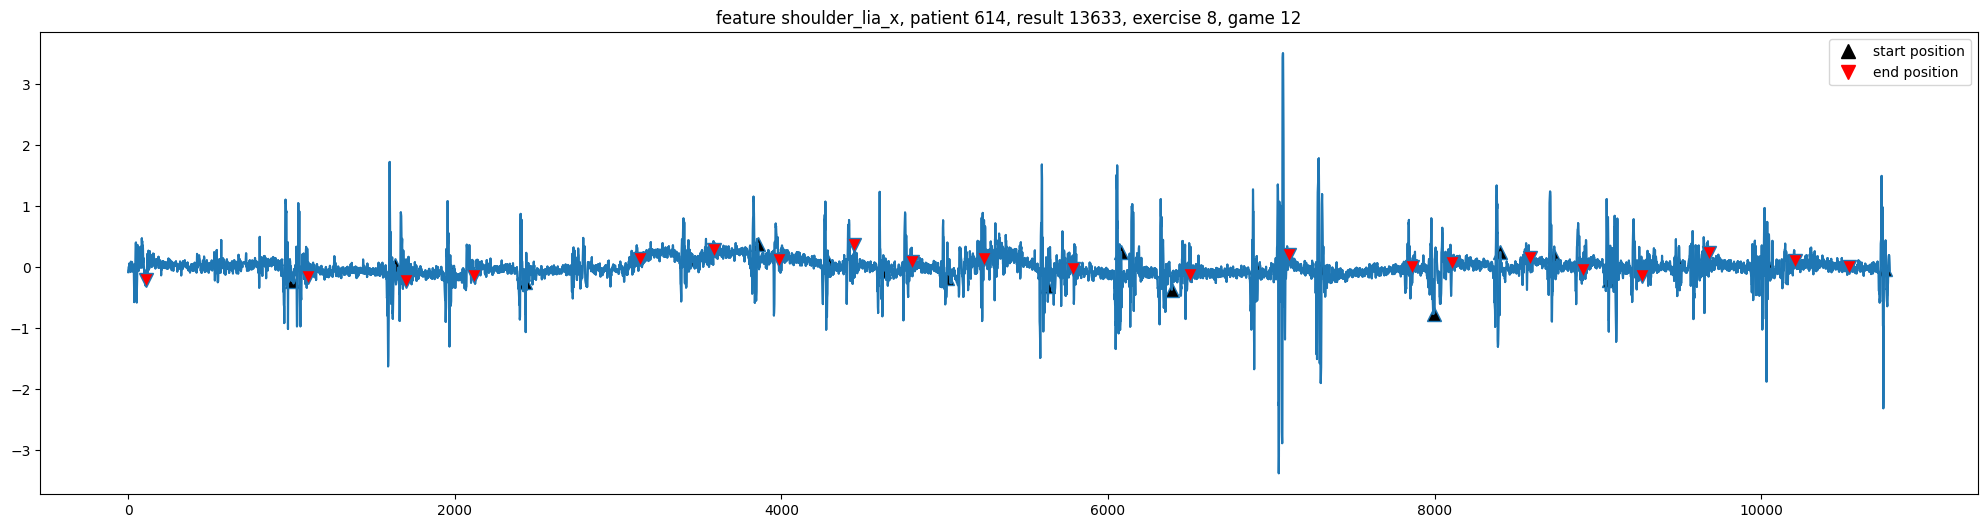

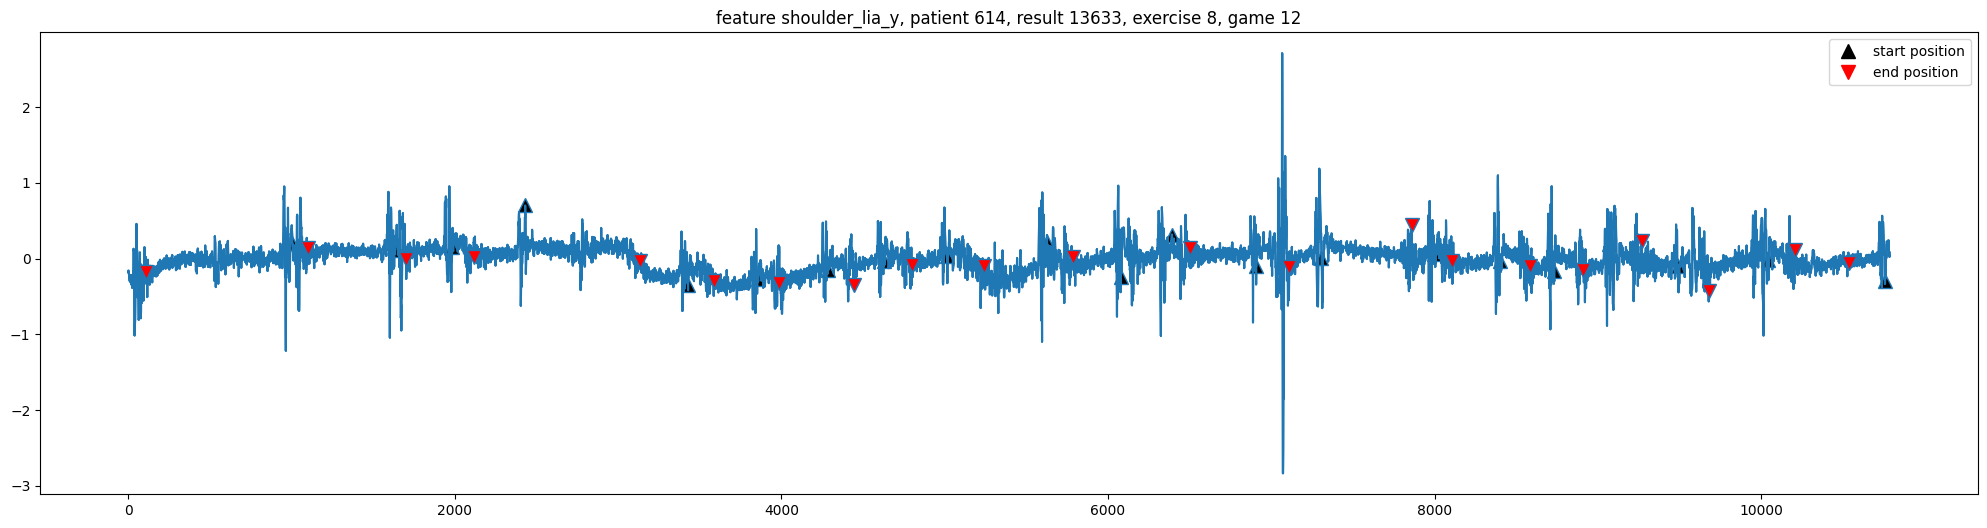

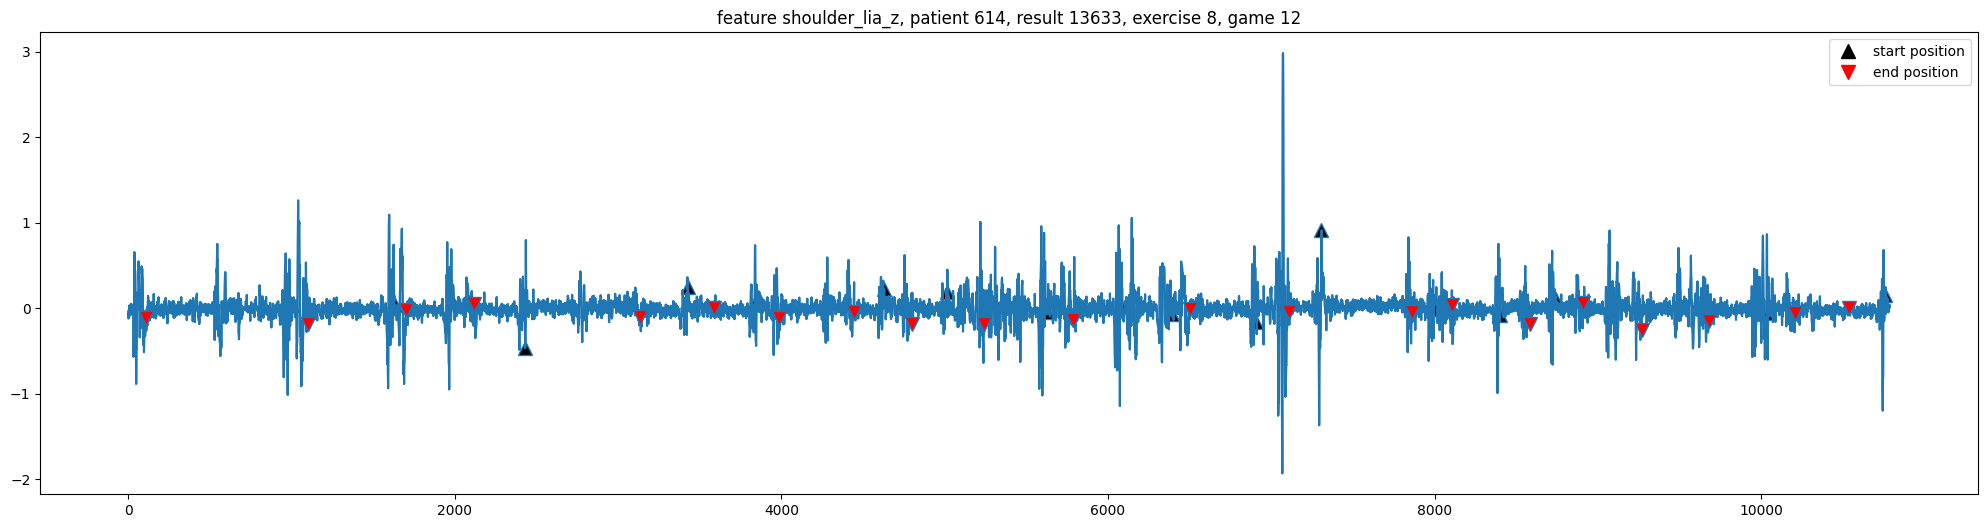

<Figure size 640x480 with 0 Axes>

In [25]:
plot_all_game_result_features(game_results_patient_2[1])